# Use cryptocompare.com REST API to gather historical cryptocurrecny data and prepair it for ML



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU

import seaborn as sn
import requests
import datetime
import json

from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

%matplotlib inline


### Insert project token here to save data so IBM cloud <br> Later you can access data without requesting the API every time

In [2]:
# The code was removed by Watson Studio for sharing.

### Functions below taken from https://github.com/Max-Pol/cryptoscrap/blob/master/cryptoscrap/history.py

In [3]:
def get_data (base_url, from_curr, to_curr, limit, to_ts, e=None, extra_params=None,
                sign=False,
                try_conversion=True, aggregate=None, 
                all_data=False):
    args = list()
    if isinstance(from_curr, str):
        args.append('fsym=' + from_curr.upper())
    if isinstance(to_curr, str):
        args.append('tsym=' + to_curr.upper())
    if e:
        args.append('e=' + e)
    if extra_params:
        args.append('extraParams=' + extra_params)
    if sign:
        args.append('sign=true')
    if aggregate:
        args.append('aggregate=' + str(aggregate))
    if limit:
        args.append('limit=' + str(limit))
    if to_ts:
        args.append('toTs=' + str(to_ts))
    if all_data:
        args.append('allData=true')
    if not try_conversion:
        args.append('tryConversion=false')
    if len(args) >= 2:
        return get_url(base_url + '&'.join(args))
    else:
        raise ValueError('Must have both fsym and tsym arguments.')    

def get_url(url):
    raw_data = requests.get(url)
    raw_data.encoding = 'utf-8'
    if raw_data.status_code != 200:
        raw_data.raise_for_status()
        return False
    try:
        if raw_data.json()['Response'] != "Success":
            raise ValueError('Cryptocompare API Error: %s'
                             % raw_data.json()['Message'])
        return raw_data.json()['Data']
    except NameError:
        raise ValueError('Cannot parse to json.')
        

### Define currencies to request

In [4]:
currencies = ('BTC', 'ETH', 'BNB', 'SOL', 'ADA', 'XRP', 'DOT', 'DOGE', 
              'AVAX', 'LUNA', 'LTC', 'MATIC', 'LHC', 'ALGO', 'VET', 'XLM','EGLD',
              'TRX', 'ATOM', 'NEAR', 'XTZ','FTM', 'HNT', 'ETC', 'MIOTA', 'STX', 'ROSE', 'HIVE',
              'EWT','DIVI','DFI', 'ZEC', 'CELO', 'XDC', 'ZIL', 'SYS', 'FLUX', 'BCD', 'DAG')

### Request API and create dicts

In [5]:
url= 'https://min-api.cryptocompare.com/data/histohour?'
limit=2000 #max is 2000
cycles = 3 #times to request the 'limit' amount of entries
to_ts = -1 #start with latest timestamp

currencies_data = dict.fromkeys(currencies, None)
currencies_columns = dict.fromkeys(currencies, None)

for currency in currencies: #go through all currecncies
    to_ts = -1
    timelist = []
    highlist = []
    lowlist = []
    openlist =[]
    closelist =[]
    volumefromlist =[]
    volumetolist =[]
    conversiontypelist = []
    conversionsymbollist = []
    for i in range(cycles): #repeat the requests but get older entries this time (differnt to_ts)
        response = get_data(url, currency, 'USD', limit, to_ts) #always in USD
        to_ts=response[0]['time']
        for i in reversed (range(limit)): #create long lists of data
            timelist.append(response[i]['time'])
            highlist.append(response[i]['high'])
            lowlist.append(response[i]['low'])
            openlist.append(response[i]['open'])
            closelist.append(response[i]['close'])
            volumefromlist.append(response[i]['volumefrom'])
            volumetolist.append(response[i]['volumeto'])
            #conversiontypelist.append(response[i]['conversionType'])
            #conversionsymbollist.append(response[i]['conversionSymbol'])
            #print(conversionsymbollist)
    #take the lists and write them to a dict for each currency
    currencies_data[currency] = [timelist, highlist, lowlist, openlist, closelist, volumefromlist, volumetolist]
    currencies_columns[currency] = ['high_'+currency,'low_'+currency,'open_'+currency,'close_'+currency,'volumefrom_'+currency,'volumeto_'+currency]#'conversiontypelist_'+currency, 'conversionsymbollist_'+currency]
#[datetime.datetime.fromtimestamp(x) for x in timelist] #change unix timestanpe to datetime object
#neueliste = [datetime.datetime.fromtimestamp(x) for x in timelist]
#print(neueliste[1])

### Rearrange data to create one dataframe

In [6]:
list_data = []
list_columns = []
data_total = {}
for snap in range(limit*cycles):    # snap = point in time a reading was done
    for currency in currencies_data.keys():  #['BTC'],....
        for attribute in range(len(currencies_data[currency])-1):        #attribute = high, low, open,.....but one less because of timelist
            list_data.append(currencies_data[currency][attribute+1][snap])  #+1 to skip timelist
    data_total[currencies_data[currency][0][snap]] = list_data
    list_data = []

for currency in currencies_data.keys():
    for i in range(len(currencies_columns[currency])):
        list_columns.append(currencies_columns[currency][i])

df = pd.DataFrame.from_dict(data_total, orient='index', columns= list_columns)
unix_list = df.index.to_list() #save unix timestamps for later
df_unix = pd.DataFrame(unix_list, columns=['unix'])#, columns='unix')
df.index = [datetime.datetime.fromtimestamp(x) for x in df.index]
df.index.name = 'datetime'
df.head(3)
#df_unix.head(3)

high_BTC   low_BTC  open_BTC  close_BTC  volumefrom_BTC  \
datetime                                                                       
2022-03-02 13:00:00  44049.69  43387.92  44018.76   43564.56         1894.37   
2022-03-02 12:00:00  44343.02  43857.03  44134.36   44018.76          836.62   
2022-03-02 11:00:00  44249.40  44043.00  44170.58   44134.36          573.30   

                     volumeto_BTC  high_ETH  low_ETH  open_ETH  close_ETH  \
datetime                                                                    
2022-03-02 13:00:00   82628365.29   2990.79  2930.67   2987.41    2940.65   
2022-03-02 12:00:00   36848412.20   3027.76  2965.11   3007.07    2987.41   
2022-03-02 11:00:00   25305198.65   3010.93  2991.41   3010.75    3007.07   

                     ...  open_BCD  close_BCD  volumefrom_BCD  volumeto_BCD  \
datetime             ...                                                      
2022-03-02 13:00:00  ...    0.7194     0.7463         3978.91       2969.61   
2022-03-02 12:00:00  ...    0.7167     0.7272       243243.19     176883.99   
2022-03-02 11:00:00  ...    0.7103     0.7167       339421.14     243277.39   

                     high_DAG  low_DAG  open_DAG  close_DAG  volumefrom_DAG  \
datetime                                                                      
2022-03-02 13:00:00    0.1403   0.1376    0.1398     0.1394         4346.94   
2022-03-02 12:00:00    0.1404   0.1383    0.1404     0.1398         4462.12   
2022-03-02 11:00:00    0.1407   0.1395    0.1400     0.1404         2122.33   

                     volumeto_DAG  
datetime                           
2022-03-02 13:00:00        605.91  
2022-03-02 12:00:00        623.85  
2022-03-02 11:00:00        298.04  

[3 rows x 234 columns]

In [7]:
#save data
project.save_data("rawdata.csv", df.to_csv(index_label='datetime'),overwrite=True)
project.save_data("unix.csv",df_unix.to_csv(index=False) ,overwrite=True)

{'file_name': 'unix.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'prepaircryptodata-donotdelete-pr-z8hqlxhhehizak',
 'asset_id': 'd9e0dafa-2e3a-422c-a51d-372397dd34c4'}

In [97]:
#load data                          
file = project.get_file("unix.csv")
df_unix = pd.read_csv(file)
file = project.get_file("rawdata.csv")                  
df_raw = pd.read_csv(file, index_col='datetime')
df_raw.index = pd.to_datetime(df_raw.index)
df_raw.sort_index(inplace=True)
df_raw.shape

(6000, 234)

### Look for currencies that have zero or nan in the data

In [98]:
for column in df_raw.columns:
    if df_raw[column].min()==0:
        print (column, 'Min:',df_raw[column].min(),'Mean:', df_raw[column].mean(), 'Max:', df_raw[column].max())
    if df_raw[column].any()==np.nan:
        print (column, 'has nan')
print('No more columns with zero or nan found')

volumefrom_LHC Min: 0 Mean: 0.0 Max: 0
volumeto_LHC Min: 0 Mean: 0.0 Max: 0
high_ROSE Min: 0.0 Mean: 0.22421398833333334 Max: 0.5972
low_ROSE Min: 0.0 Mean: 0.21859507166666667 Max: 0.5856
open_ROSE Min: 0.0 Mean: 0.22125029666666668 Max: 0.5892
close_ROSE Min: 0.0 Mean: 0.22129253666666668 Max: 0.5892
volumefrom_ROSE Min: 0.0 Mean: 414524.8861133333 Max: 36814502.0
volumeto_ROSE Min: 0.0 Mean: 74550.68990433334 Max: 10298689.82
volumefrom_EWT Min: 0.0 Mean: 3087.936343116667 Max: 496346.16
volumeto_EWT Min: 0.0 Mean: 28061.206285 Max: 5254891.29
volumefrom_DIVI Min: 0.0 Mean: 32548.4421845 Max: 1697921.52
volumeto_DIVI Min: 0.0 Mean: 2467.012124131667 Max: 120552.43
volumefrom_XDC Min: 0.0 Mean: 98642.45139966666 Max: 16771469.42
volumeto_XDC Min: 0.0 Mean: 10335.41061218 Max: 1783066.26
volumefrom_SYS Min: 0.0 Mean: 350752.28641833336 Max: 43676113.99
volumeto_SYS Min: 0.0 Mean: 153688.82918166666 Max: 25106949.27
high_FLUX Min: 0.0 Mean: 0.9721918833333333 Max: 3.43
low_FLUX Min: 0.

### Create selections of features

In [99]:
#new lists for different categories

closes =  []
# volumefrom = []
# volumeto = []

for i in range(len(list(df_raw.columns))):
    if 'close' in df_raw.columns[i]:
        closes.append(list(df_raw.columns)[i])
        
# for i in range(len(list(df_raw.columns))):
#     if 'volumefrom' in df_raw.columns[i]:
#         volumefrom.append(list(df_raw.columns)[i])

# for i in range(len(list(df_raw.columns))):
#     if 'volumeto' in df_raw.columns[i]:
#         volumeto.append(list(df_raw.columns)[i])

### Only look at the "close" data, skip volume for now, because data is not matching with the website

In [100]:
df_close = df_raw[closes]
df_close.head(3)

close_BTC  close_ETH  close_BNB  close_SOL  close_ADA  \
datetime                                                                     
2021-06-25 14:00:00   32746.53    1823.08     287.69      29.44      1.290   
2021-06-25 15:00:00   32558.07    1825.72     286.73      29.00      1.271   
2021-06-25 16:00:00   31913.67    1816.66     279.78      28.67      1.259   

                     close_XRP  close_DOT  close_DOGE  close_AVAX  close_LUNA  \
datetime                                                                        
2021-06-25 14:00:00     0.6369      15.12      0.2576       10.60       5.164   
2021-06-25 15:00:00     0.6229      15.01      0.2526       10.48       5.164   
2021-06-25 16:00:00     0.6081      14.74      0.2372       10.40       5.030   

                     ...  close_DIVI  close_DFI  close_ZEC  close_CELO  \
datetime             ...                                                 
2021-06-25 14:00:00  ...     0.03733      2.592     105.51       2.902   
2021-06-25 15:00:00  ...     0.03712      2.554     104.62       3.021   
2021-06-25 16:00:00  ...     0.03638      2.517     102.54       3.032   

                     close_XDC  close_ZIL  close_SYS  close_FLUX  close_BCD  \
datetime                                                                      
2021-06-25 14:00:00    0.05401    0.07171     0.1140         0.0      1.956   
2021-06-25 15:00:00    0.05359    0.07151     0.1120         0.0      1.951   
2021-06-25 16:00:00    0.05320    0.07104     0.1104         0.0      1.929   

                     close_DAG  
datetime                        
2021-06-25 14:00:00    0.06071  
2021-06-25 15:00:00    0.05696  
2021-06-25 16:00:00    0.05722  

[3 rows x 39 columns]

### Plot all currencies in separate plots to look for unusuall behavior

<Figure size 432x288 with 0 Axes>

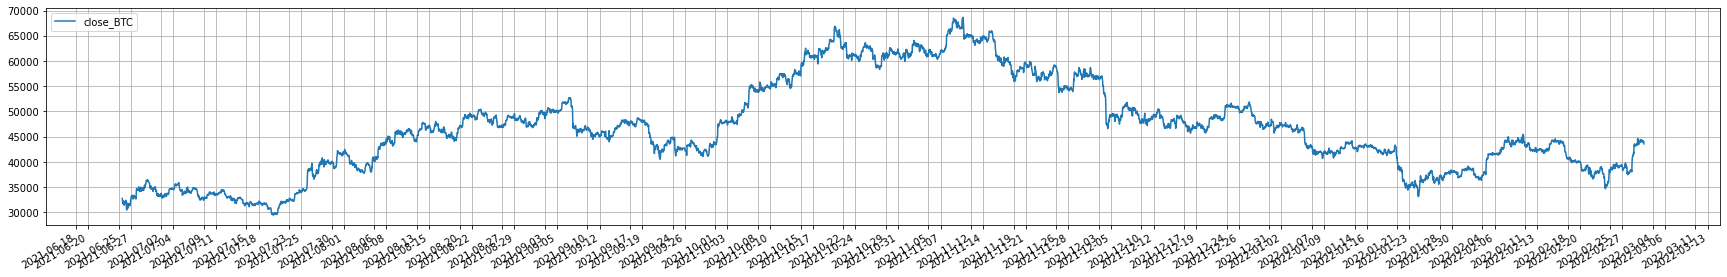

<Figure size 432x288 with 0 Axes>

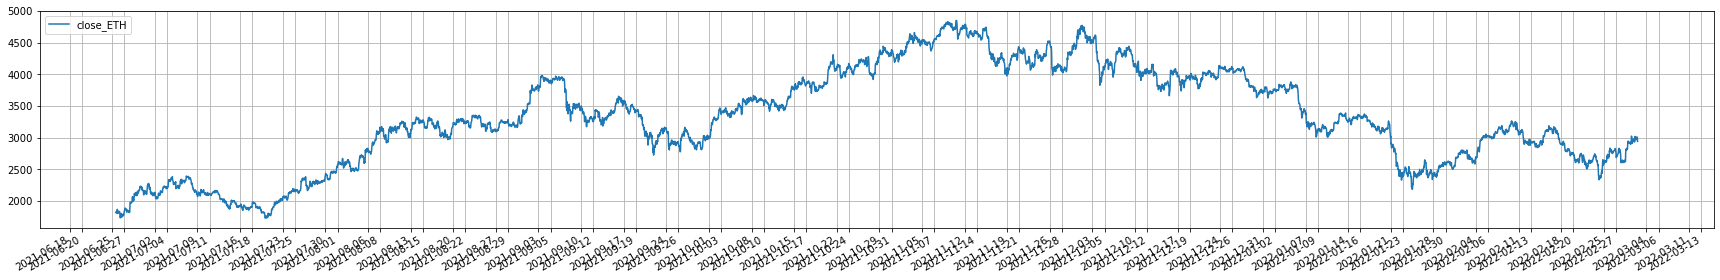

<Figure size 432x288 with 0 Axes>

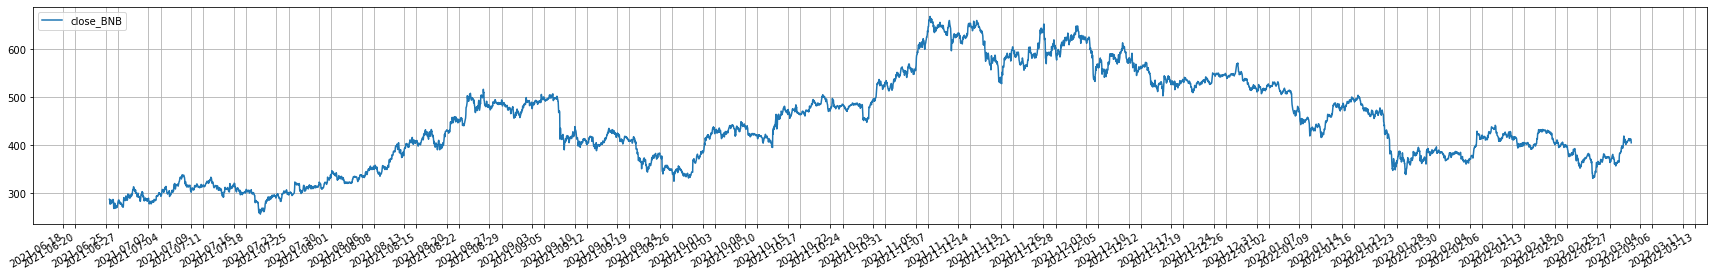

<Figure size 432x288 with 0 Axes>

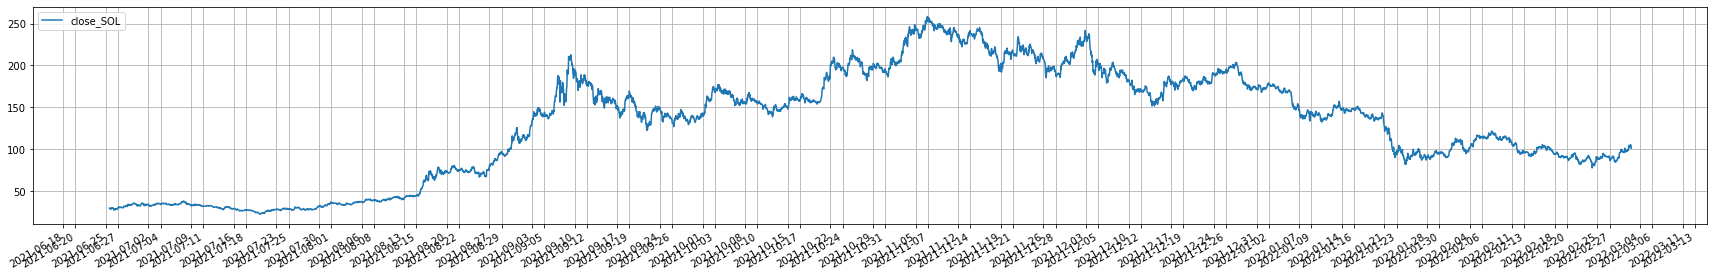

<Figure size 432x288 with 0 Axes>

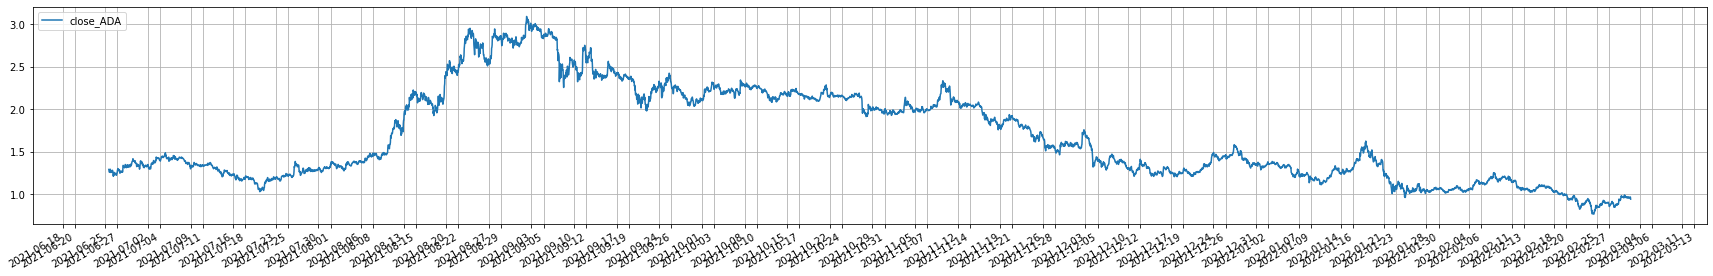

<Figure size 432x288 with 0 Axes>

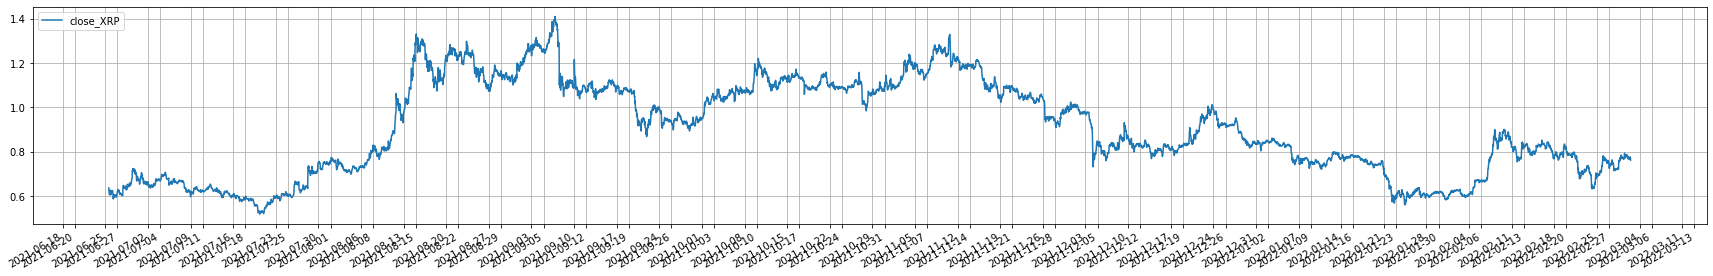

<Figure size 432x288 with 0 Axes>

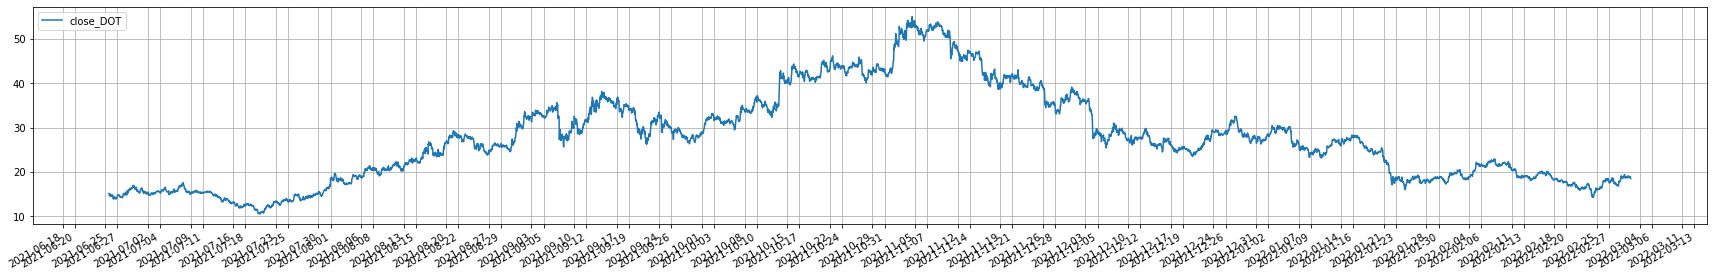

<Figure size 432x288 with 0 Axes>

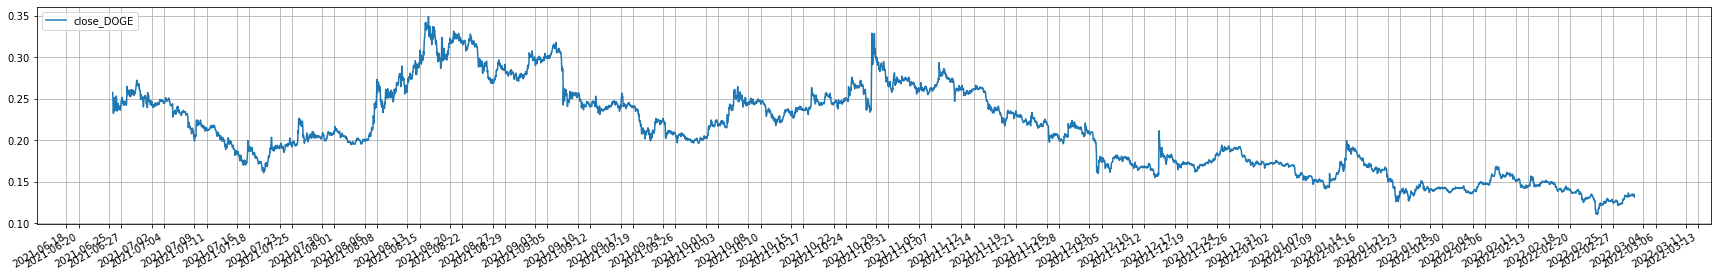

<Figure size 432x288 with 0 Axes>

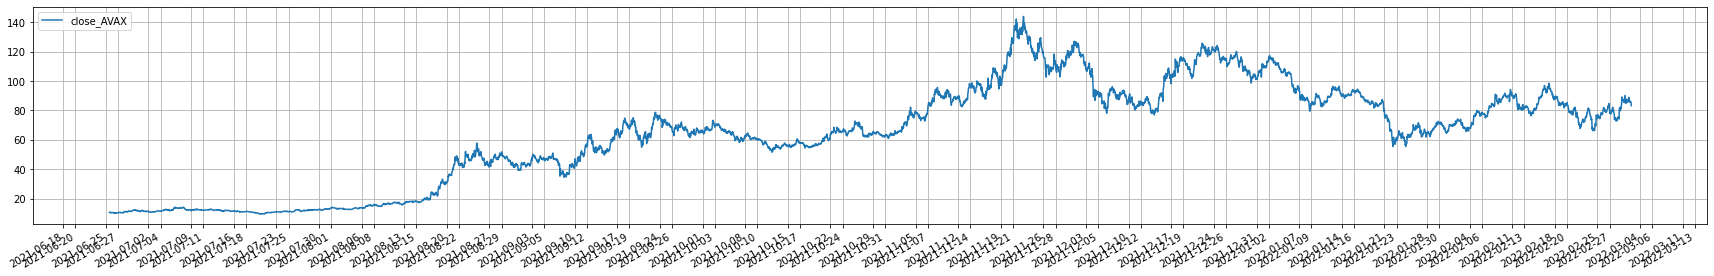

<Figure size 432x288 with 0 Axes>

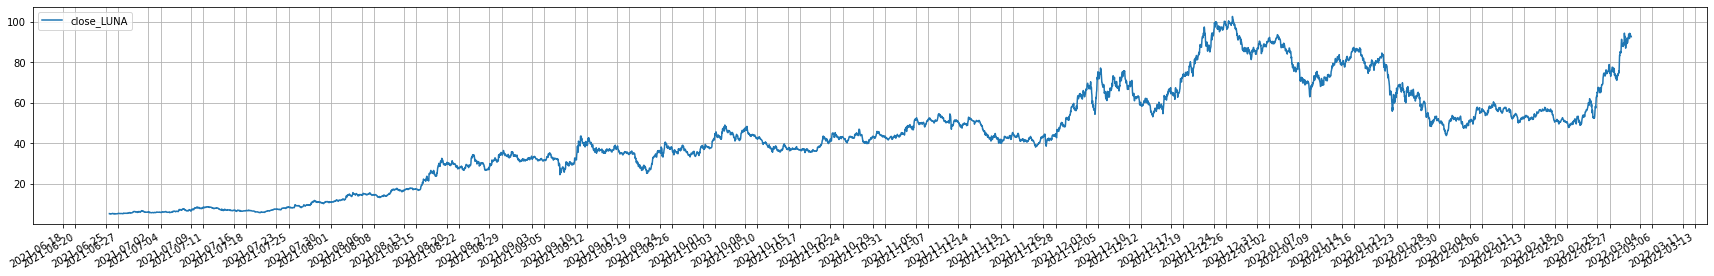

<Figure size 432x288 with 0 Axes>

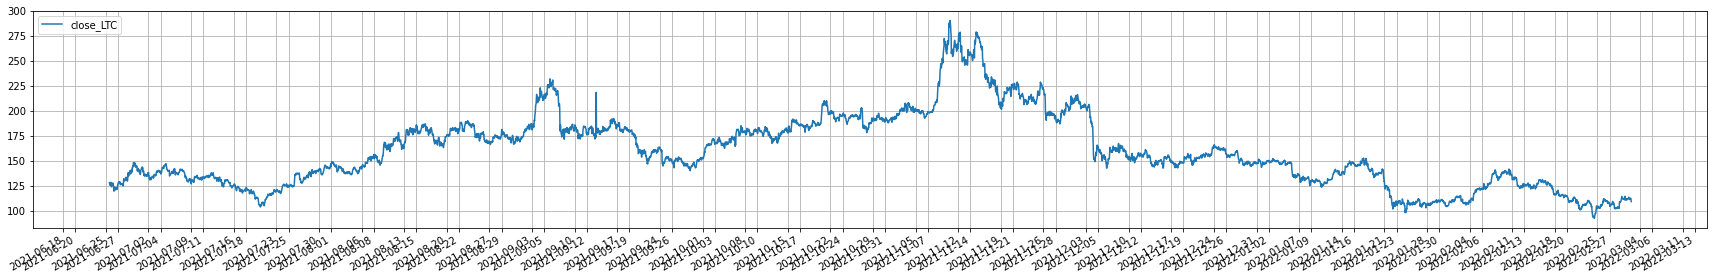

<Figure size 432x288 with 0 Axes>

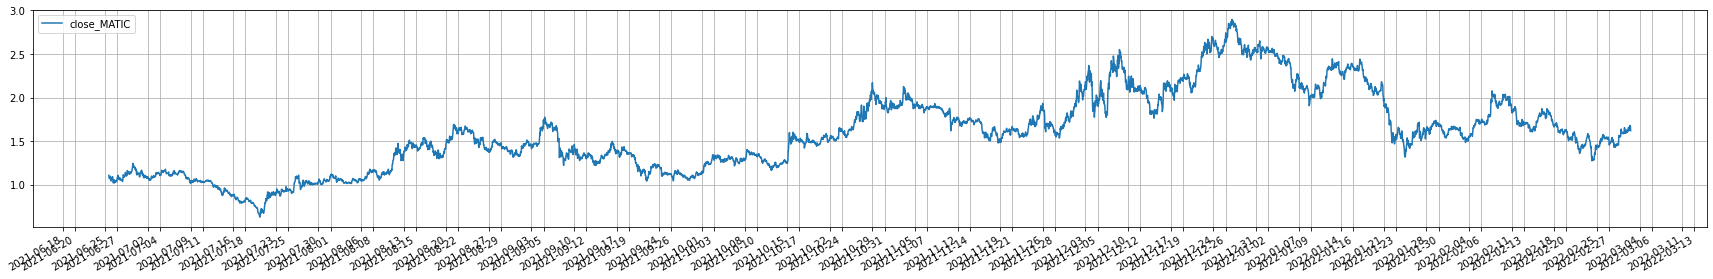

<Figure size 432x288 with 0 Axes>

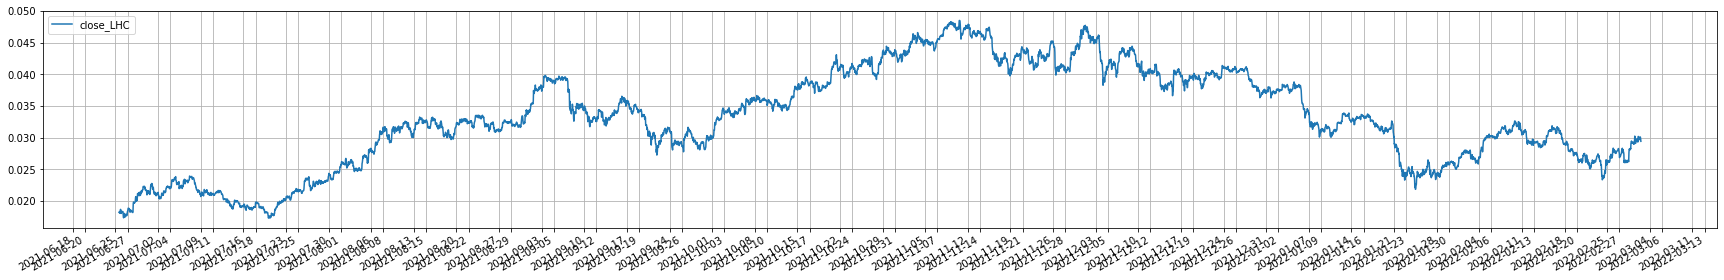

<Figure size 432x288 with 0 Axes>

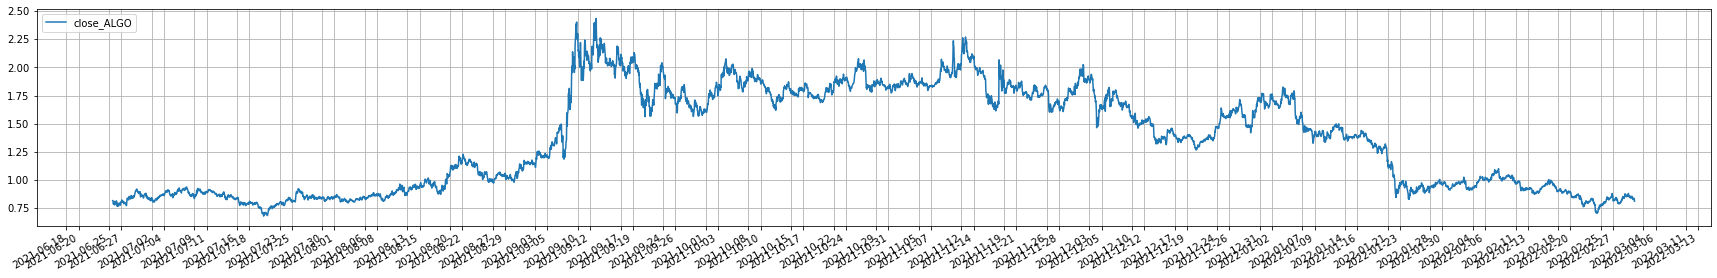

<Figure size 432x288 with 0 Axes>

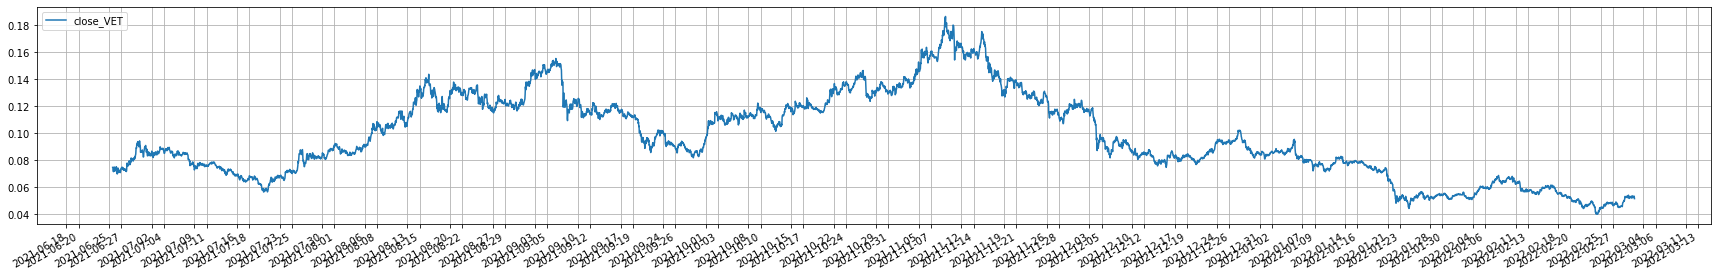

<Figure size 432x288 with 0 Axes>

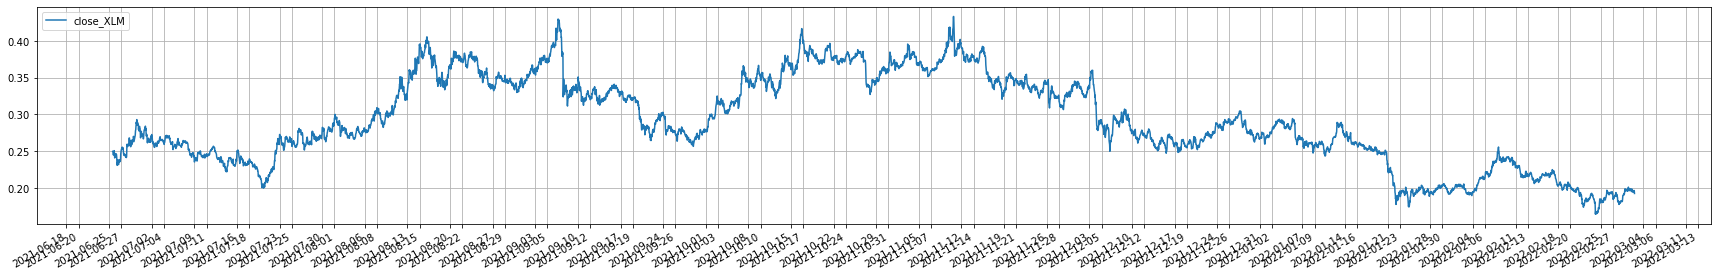

<Figure size 432x288 with 0 Axes>

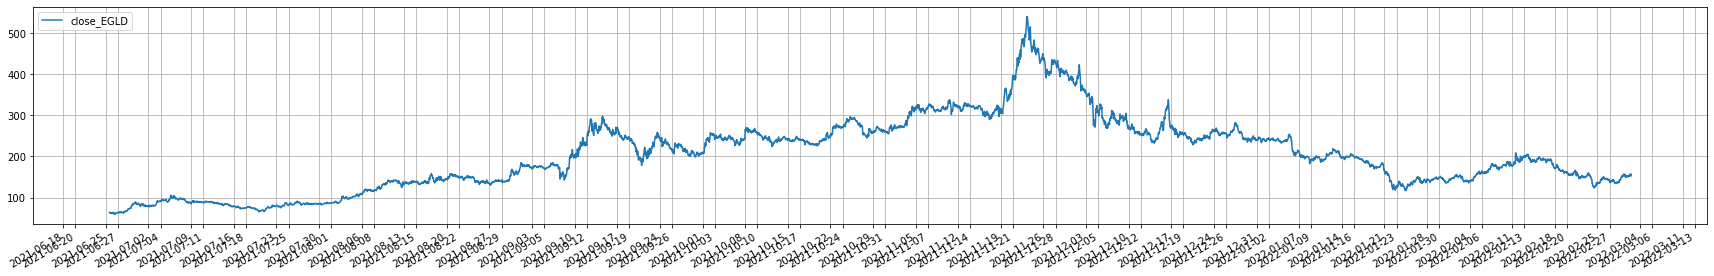

<Figure size 432x288 with 0 Axes>

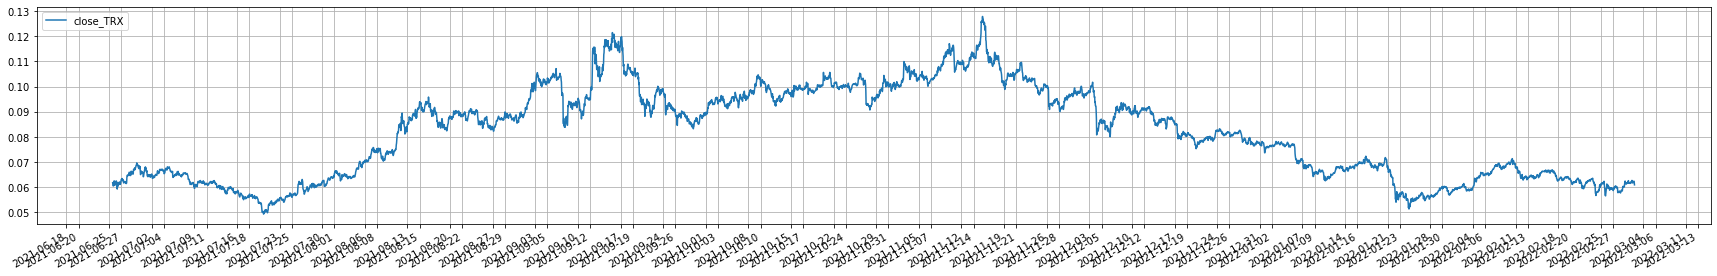

<Figure size 432x288 with 0 Axes>

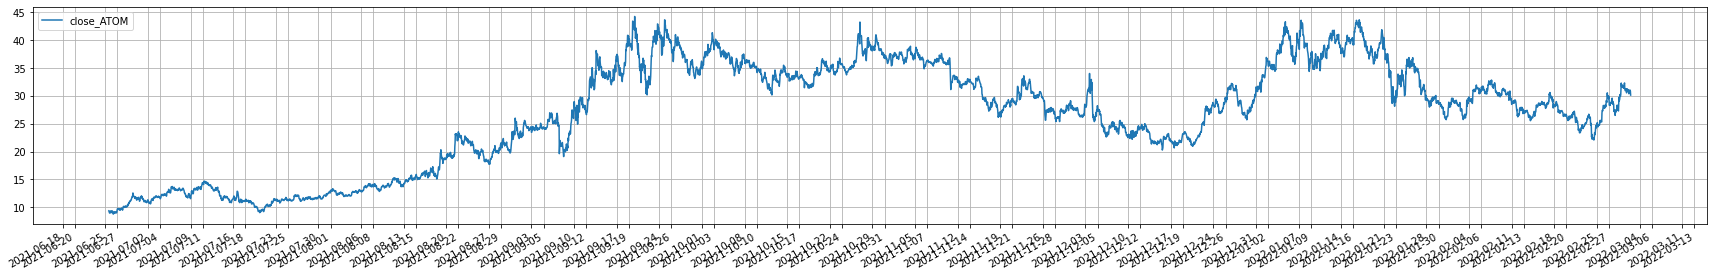

<Figure size 432x288 with 0 Axes>

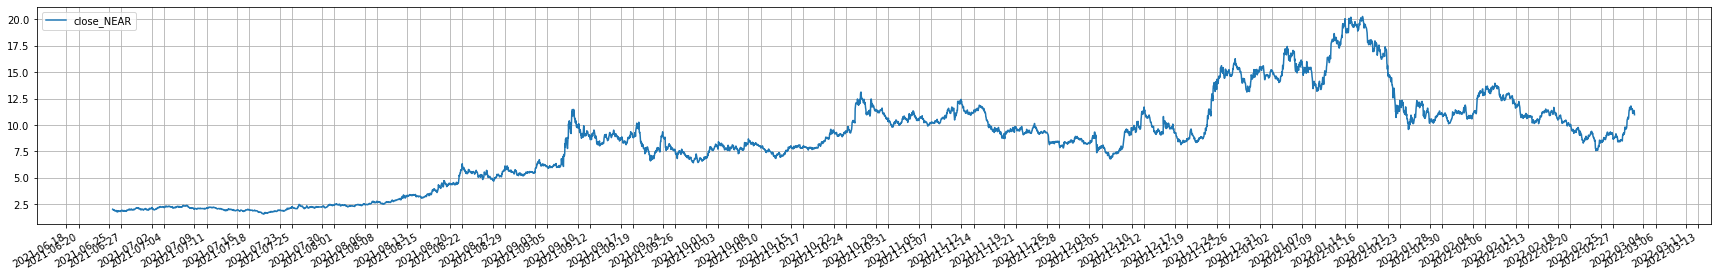

<Figure size 432x288 with 0 Axes>

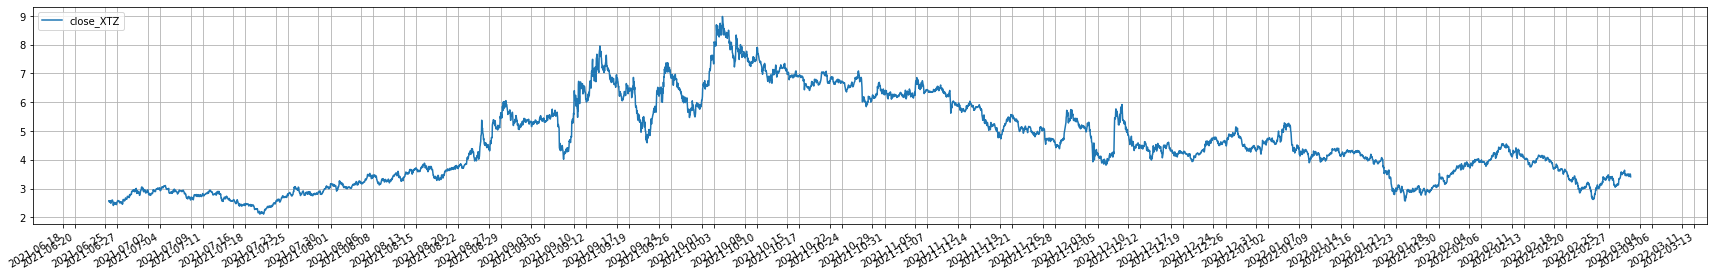

<Figure size 432x288 with 0 Axes>

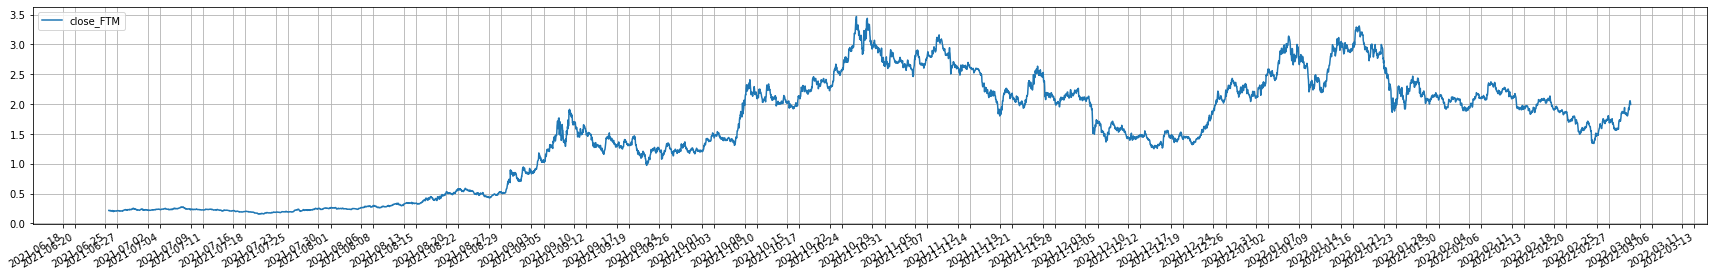

<Figure size 432x288 with 0 Axes>

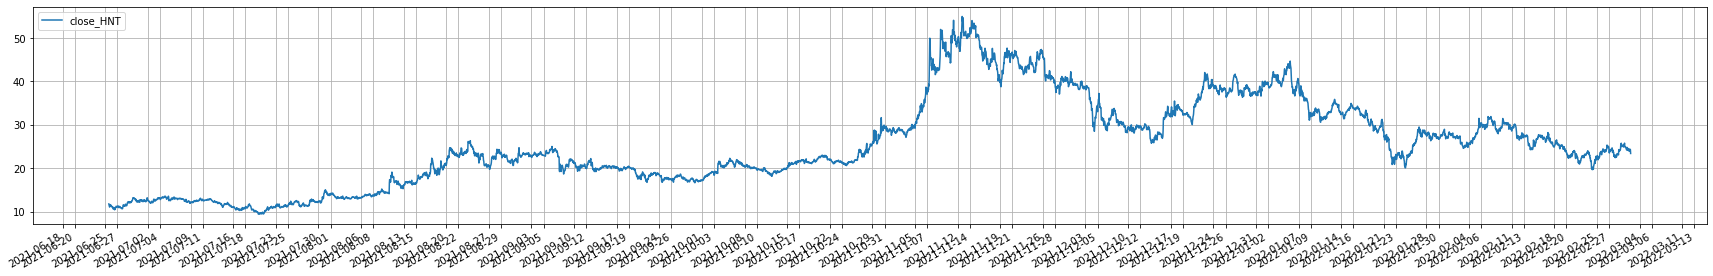

<Figure size 432x288 with 0 Axes>

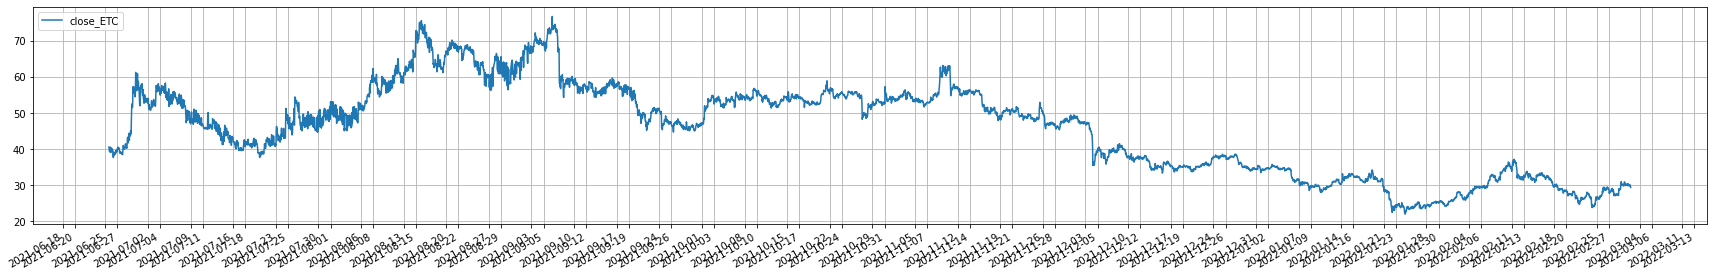

<Figure size 432x288 with 0 Axes>

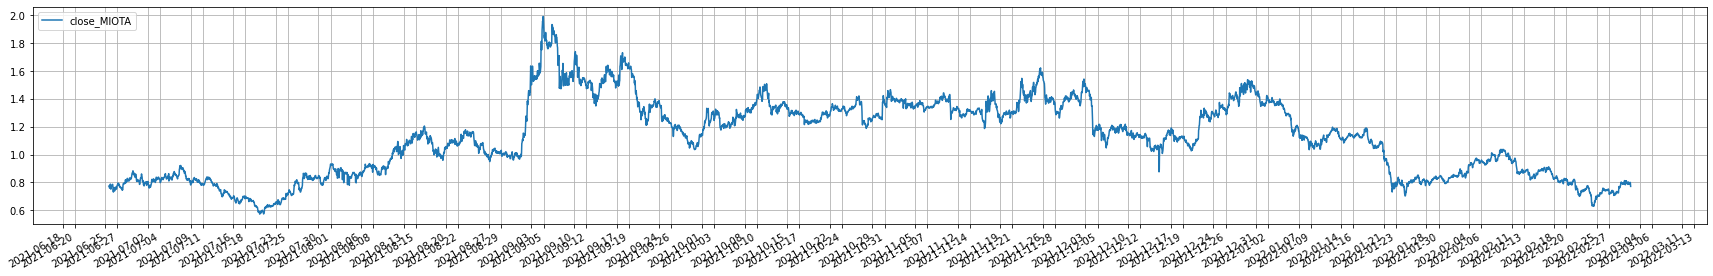

<Figure size 432x288 with 0 Axes>

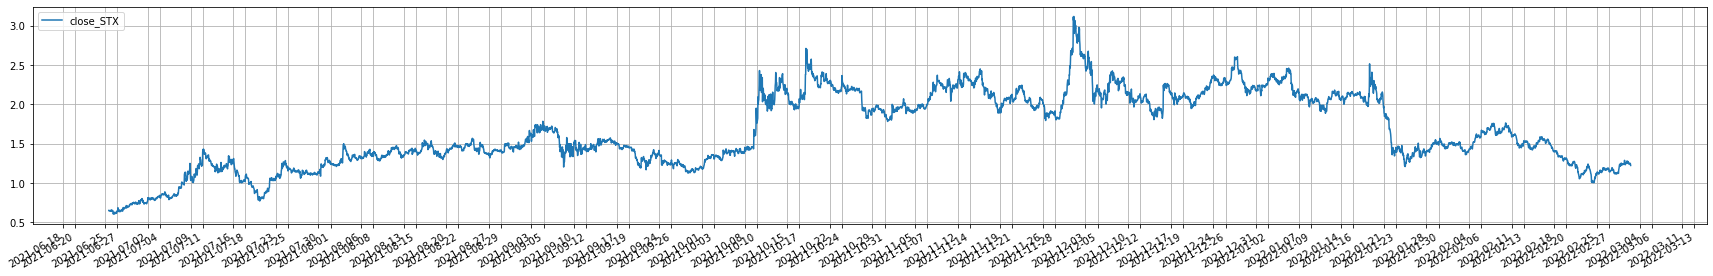

<Figure size 432x288 with 0 Axes>

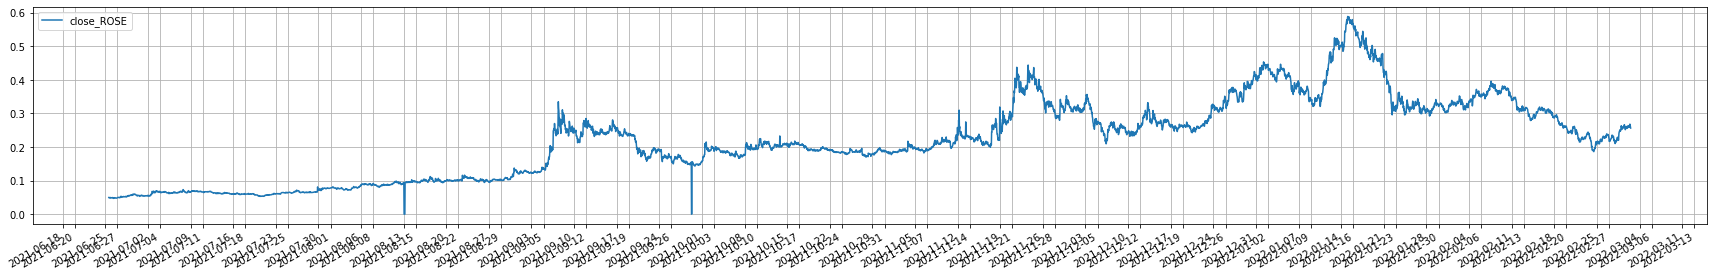

<Figure size 432x288 with 0 Axes>

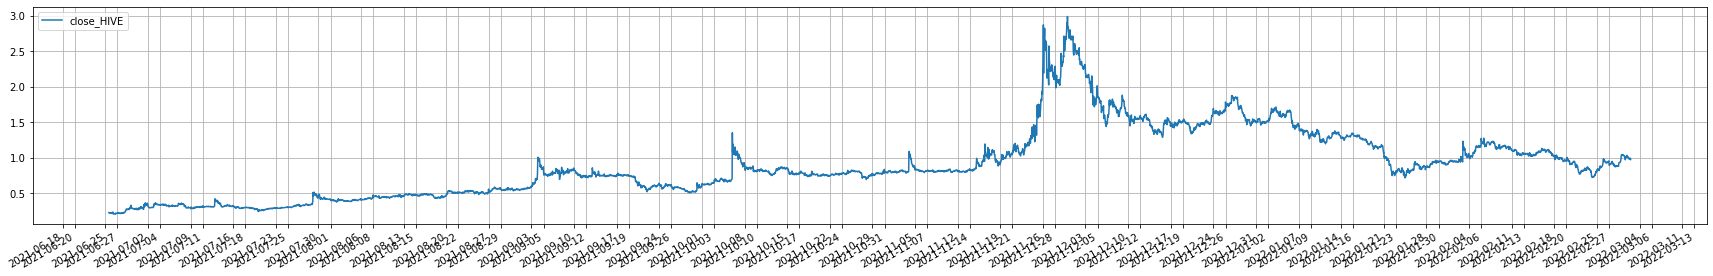

<Figure size 432x288 with 0 Axes>

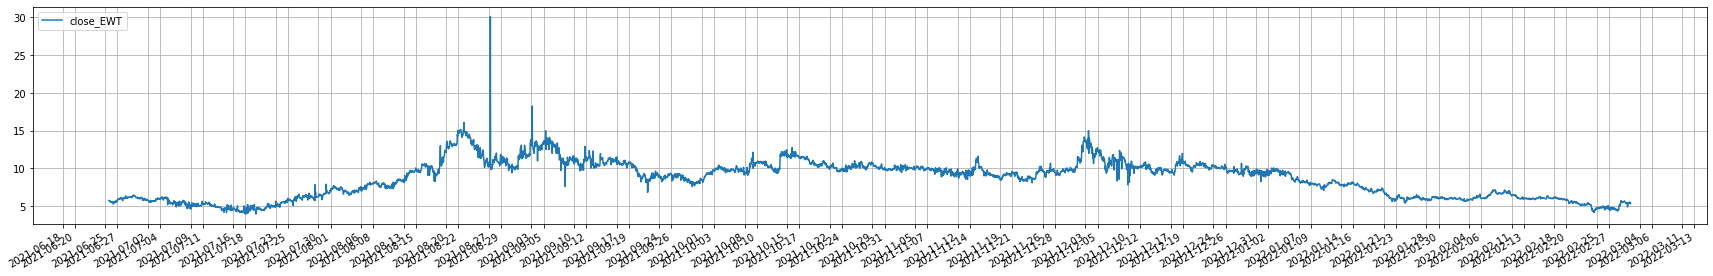

<Figure size 432x288 with 0 Axes>

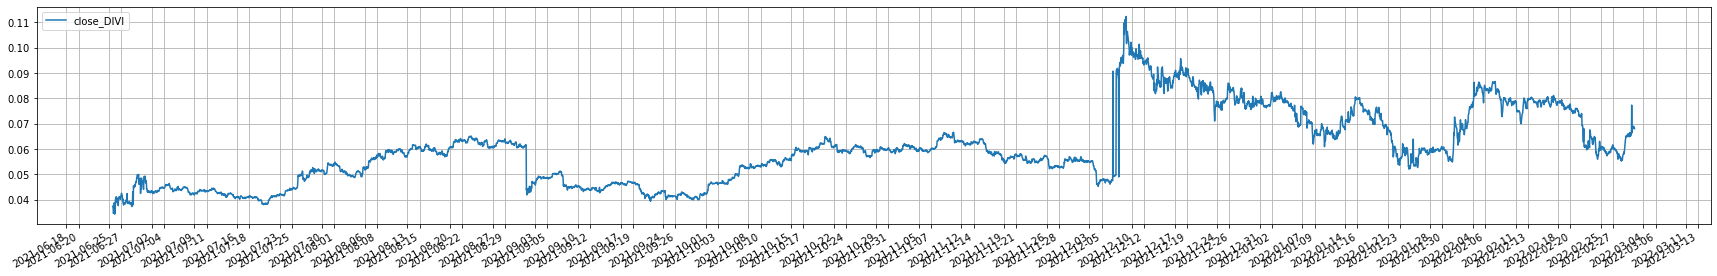

<Figure size 432x288 with 0 Axes>

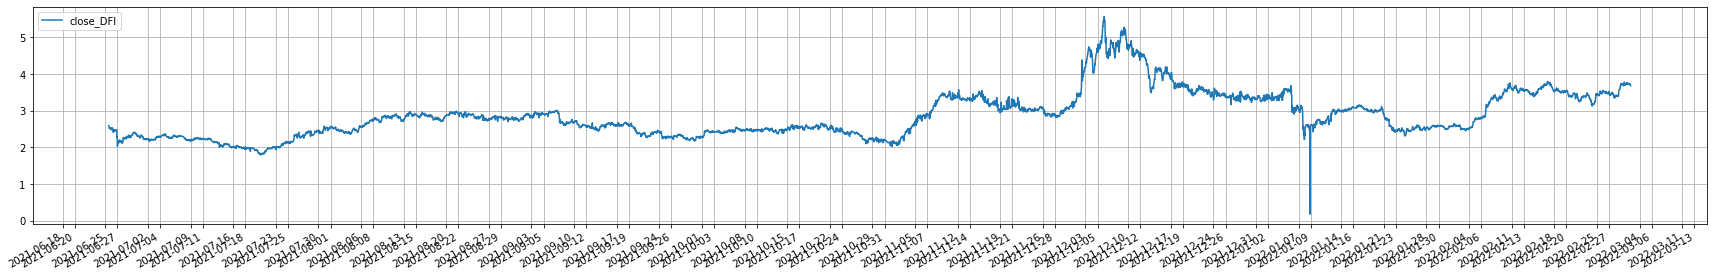

<Figure size 432x288 with 0 Axes>

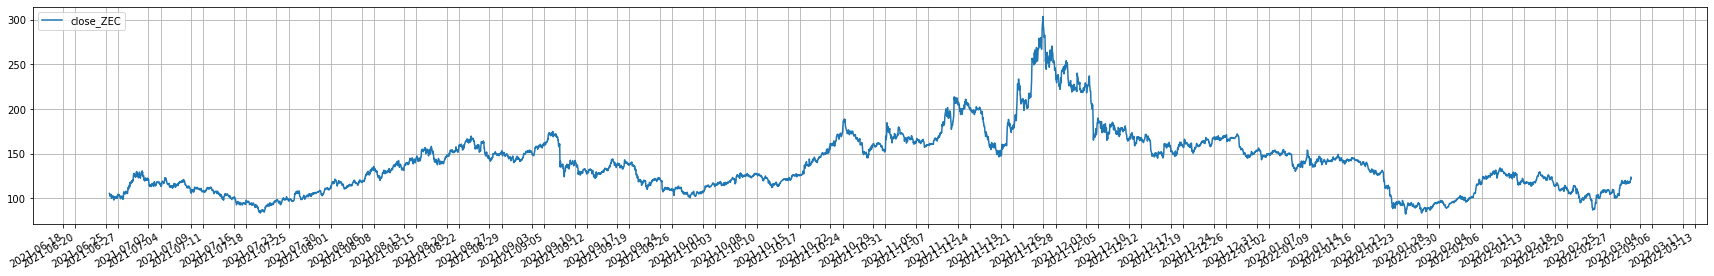

<Figure size 432x288 with 0 Axes>

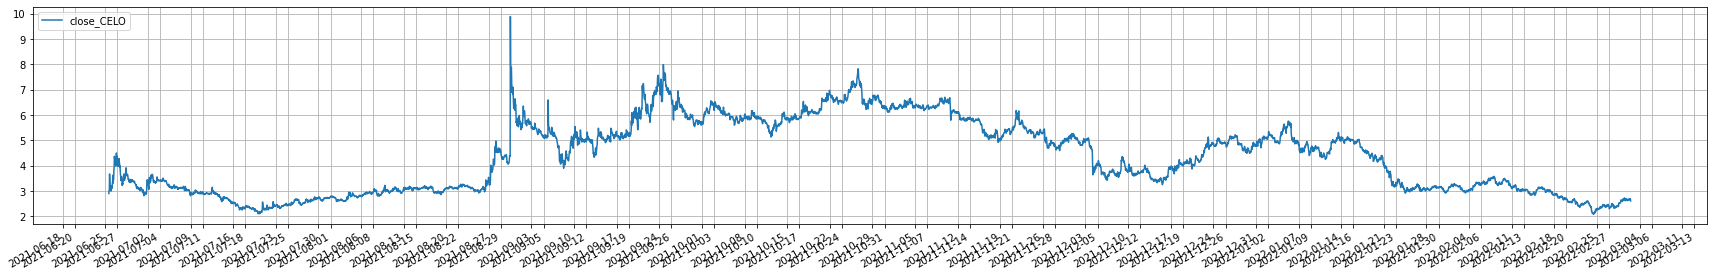

<Figure size 432x288 with 0 Axes>

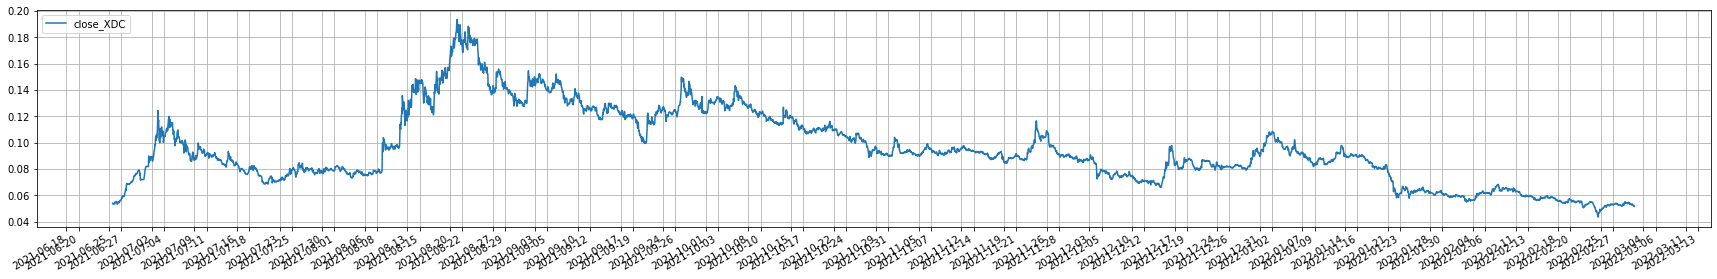

<Figure size 432x288 with 0 Axes>

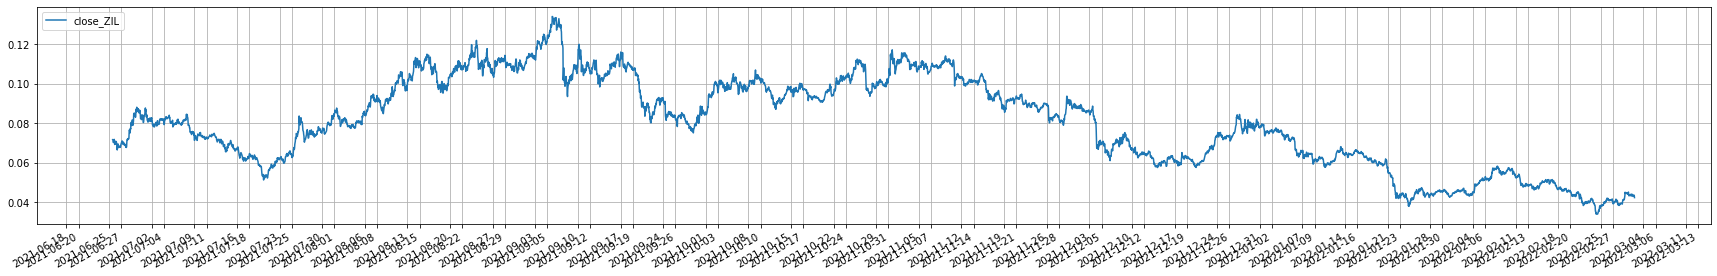

<Figure size 432x288 with 0 Axes>

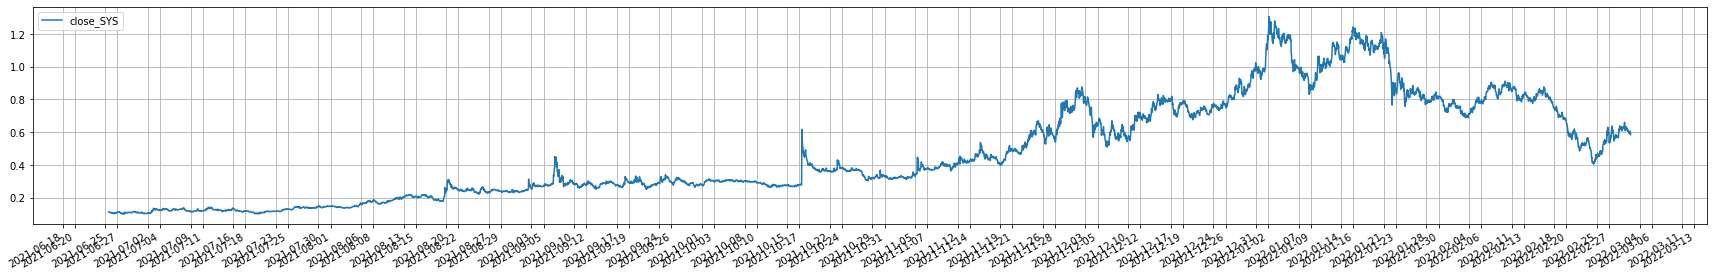

<Figure size 432x288 with 0 Axes>

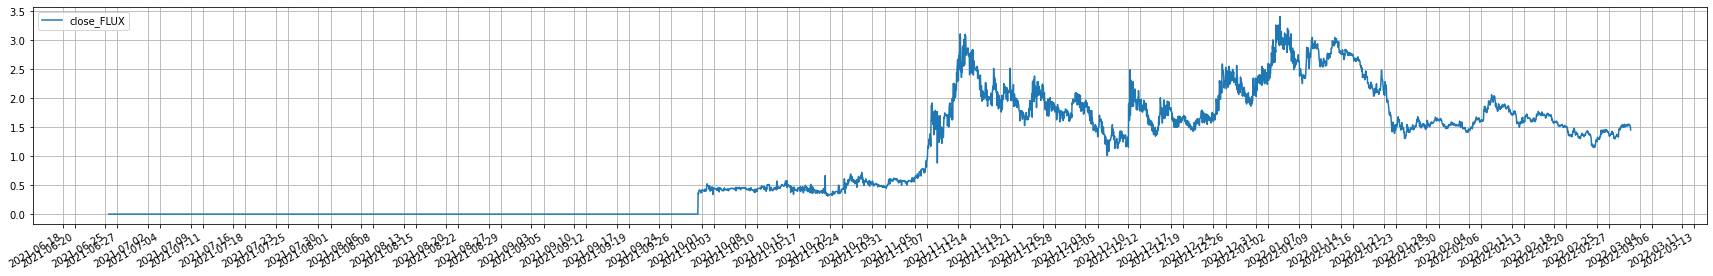

<Figure size 432x288 with 0 Axes>

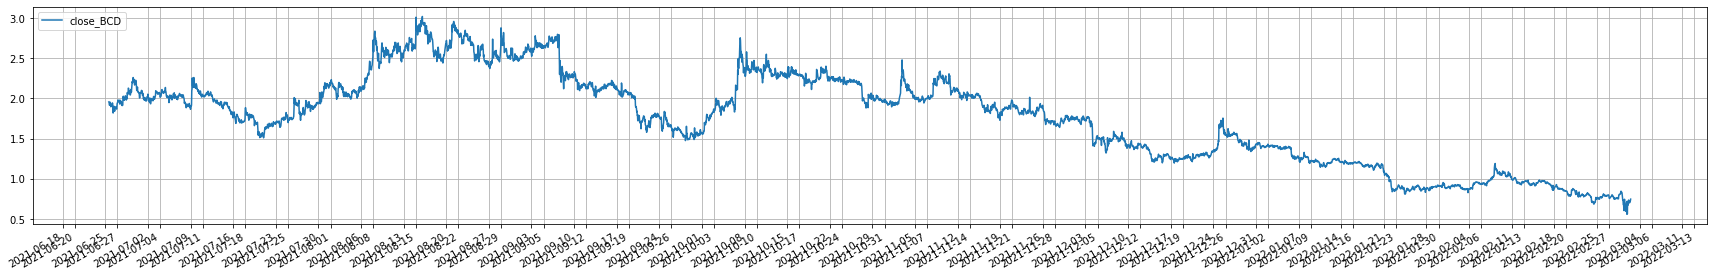

<Figure size 432x288 with 0 Axes>

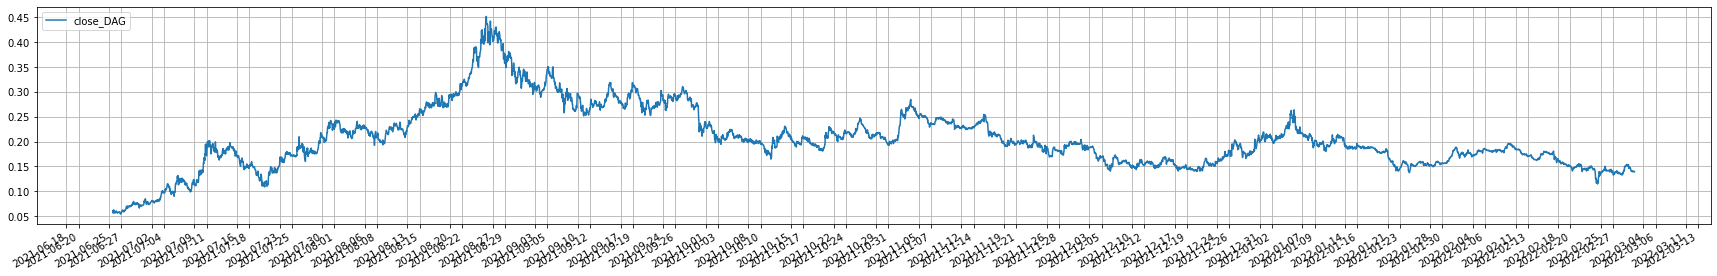

In [120]:
locator = mdates.WeekdayLocator((FR, SU)) #markers for the weekend, will be time periode for prediction later
formatter = mdates.DateFormatter("%Y-%m-%d") 

for entry in df_close: 
    plt.clf()
    fig, ax = plt.subplots(figsize=(30,4))
    #ax.set_yscale('log')
    ax.plot(df_close.index, df_close[entry])
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.grid(True)
    plt.xticks(rotation=30, ha='right')
    plt.legend([entry],loc="upper left")
    plt.show()

### Delete currencies which are incomplete (currency too young or zero for a periode)

In [102]:
try:
    df_close.drop([['close_FLUX']],axis='columns', inplace=True)
except Exception:
    print("Exception skipped, maybe columns were not in df")
df_close.head(3)

Exception skipped, maybe columns were not in df


close_BTC  close_ETH  close_BNB  close_SOL  close_ADA  \
datetime                                                                     
2021-06-25 14:00:00   32746.53    1823.08     287.69      29.44      1.290   
2021-06-25 15:00:00   32558.07    1825.72     286.73      29.00      1.271   
2021-06-25 16:00:00   31913.67    1816.66     279.78      28.67      1.259   

                     close_XRP  close_DOT  close_DOGE  close_AVAX  close_LUNA  \
datetime                                                                        
2021-06-25 14:00:00     0.6369      15.12      0.2576       10.60       5.164   
2021-06-25 15:00:00     0.6229      15.01      0.2526       10.48       5.164   
2021-06-25 16:00:00     0.6081      14.74      0.2372       10.40       5.030   

                     ...  close_DIVI  close_DFI  close_ZEC  close_CELO  \
datetime             ...                                                 
2021-06-25 14:00:00  ...     0.03733      2.592     105.51       2.902   
2021-06-25 15:00:00  ...     0.03712      2.554     104.62       3.021   
2021-06-25 16:00:00  ...     0.03638      2.517     102.54       3.032   

                     close_XDC  close_ZIL  close_SYS  close_FLUX  close_BCD  \
datetime                                                                      
2021-06-25 14:00:00    0.05401    0.07171     0.1140         0.0      1.956   
2021-06-25 15:00:00    0.05359    0.07151     0.1120         0.0      1.951   
2021-06-25 16:00:00    0.05320    0.07104     0.1104         0.0      1.929   

                     close_DAG  
datetime                        
2021-06-25 14:00:00    0.06071  
2021-06-25 15:00:00    0.05696  
2021-06-25 16:00:00    0.05722  

[3 rows x 39 columns]

### Define currencies that have suspected outlier in the data <br> In this case LTC, ROSE, EWT, DIVI, DFI, CELO look suspicious, they will be treated to detect the outliers

In [103]:
currencies_anomalies = ['close_LTC', 'close_ROSE', 'close_EWT', 'close_DIVI', 'close_DFI', 'close_CELO']
named_anomalies =[]

for currency in currencies_anomalies:
    named_anomalies.append(currency+'_anomaly')    

### From here on normalized data will be used (Z-Norm)<br> Indexes are not normalized, this could make a diference in outlier detection <br> Option to switch to unix timestamp if necessary

In [104]:
x = df_close.values #returns a numpy array
x_Zscaled = preprocessing.StandardScaler().fit_transform(x)
df_close_Znorm = pd.DataFrame(x_Zscaled, index= df_close.index, columns= df_close.columns)
df_close_Znorm.sort_index(inplace=True)
#df_close_Znorm.set_index(df_unix['unix'], inplace=True)
df_close_Znorm.head(10)

close_BTC  close_ETH  close_BNB  close_SOL  close_ADA  \
datetime                                                                     
2021-06-25 14:00:00  -1.533460  -1.955371  -1.602123  -1.537969  -0.708546   
2021-06-25 15:00:00  -1.554242  -1.951910  -1.611962  -1.544761  -0.743318   
2021-06-25 16:00:00  -1.625301  -1.963787  -1.683190  -1.549855  -0.765280   
2021-06-25 17:00:00  -1.652452  -1.977238  -1.707479  -1.555411  -0.770770   
2021-06-25 18:00:00  -1.608671  -1.937266  -1.648037  -1.549237  -0.725017   
2021-06-25 19:00:00  -1.590959  -1.917942  -1.617291  -1.538278  -0.708546   
2021-06-25 20:00:00  -1.591755  -1.897332  -1.619443  -1.536734  -0.704886   
2021-06-25 21:00:00  -1.639250  -1.921140  -1.649882  -1.545841  -0.741488   
2021-06-25 22:00:00  -1.681904  -1.982155  -1.693029  -1.554794  -0.774430   
2021-06-25 23:00:00  -1.660566  -1.972165  -1.671302  -1.550472  -0.772600   

                     close_XRP  close_DOT  close_DOGE  close_AVAX  close_LUNA  \
datetime                                                                        
2021-06-25 14:00:00  -1.282507  -1.226945    0.893885   -1.595483   -1.602156   
2021-06-25 15:00:00  -1.349678  -1.237767    0.795503   -1.599042   -1.602156   
2021-06-25 16:00:00  -1.420688  -1.264328    0.492486   -1.601414   -1.607710   
2021-06-25 17:00:00  -1.430763  -1.280069    0.396072   -1.603490   -1.613138   
2021-06-25 18:00:00  -1.378946  -1.250556    0.539710   -1.601711   -1.609533   
2021-06-25 19:00:00  -1.352557  -1.242686    0.647930   -1.598449   -1.605430   
2021-06-25 20:00:00  -1.329527  -1.239734    0.767956   -1.595187   -1.605223   
2021-06-25 21:00:00  -1.351118  -1.256458    0.628254   -1.598745   -1.607751   
2021-06-25 22:00:00  -1.428844  -1.282036    0.455101   -1.606752   -1.608497   
2021-06-25 23:00:00  -1.400536  -1.293841    0.508227   -1.605863   -1.606673   

                     ...  close_DIVI  close_DFI  close_ZEC  close_CELO  \
datetime             ...                                                 
2021-06-25 14:00:00  ...   -1.598995  -0.455787  -0.969744   -1.037561   
2021-06-25 15:00:00  ...   -1.613889  -0.517743  -0.995330   -0.952395   
2021-06-25 16:00:00  ...   -1.666373  -0.578069  -1.055127   -0.944522   
2021-06-25 17:00:00  ...   -1.798292  -0.586221  -1.040178   -0.485054   
2021-06-25 18:00:00  ...   -1.767795  -0.543830  -1.003380   -0.696180   
2021-06-25 19:00:00  ...   -1.755028  -0.578069  -1.019766   -0.847905   
2021-06-25 20:00:00  ...   -1.504665  -0.566656  -0.999355   -0.835023   
2021-06-25 21:00:00  ...   -1.541546  -0.589482  -1.011142   -0.888699   
2021-06-25 22:00:00  ...   -1.818860  -0.626982  -1.126999   -0.963846   
2021-06-25 23:00:00  ...   -1.781980  -0.620460  -1.115499   -0.967424   

                     close_XDC  close_ZIL  close_SYS  close_FLUX  close_BCD  \
datetime                                                                      
2021-06-25 14:00:00  -1.462599  -0.404024  -1.187226   -1.000604   0.340146   
2021-06-25 15:00:00  -1.477514  -0.412951  -1.193808   -1.000604   0.331200   
2021-06-25 16:00:00  -1.491363  -0.433932  -1.199073   -1.000604   0.291839   
2021-06-25 17:00:00  -1.489232  -0.469196  -1.199731   -1.000604   0.265001   
2021-06-25 18:00:00  -1.490298  -0.430807  -1.196111   -1.000604   0.332989   
2021-06-25 19:00:00  -1.481420  -0.413844  -1.192162   -1.000604   0.334778   
2021-06-25 20:00:00  -1.477514  -0.397328  -1.194466   -1.000604   0.315098   
2021-06-25 21:00:00  -1.470056  -0.433039  -1.199402   -1.000604   0.281104   
2021-06-25 22:00:00  -1.475028  -0.512496  -1.206970   -1.000604   0.232797   
2021-06-25 23:00:00  -1.478934  -0.492409  -1.201705   -1.000604   0.256056   

                     close_DAG  
datetime                        
2021-06-25 14:00:00  -2.291359  
2021-06-25 15:00:00  -2.351021  
2021-06-25 16:00:00  -2.346885  
2021-06-25 17:00:00  -2.357704  
2021-06-25 18:00:00  -2.258107  
2021-06-25 19:00:00  -2.288018  
2021-06-2

# Identify outliers automatically for a subset of currencies and replace the values (WIP)

Methodes tested:
<br>
-IsolationForest(contamination= 0.0015) 
not working that well because it detects extreme values without considering the neighboring datapoints.
Misses two suspected outliers of ROSE
<br>
-OneClassSVM(gamma=0.0001, nu=0.001)
similar results than LOF. But two parameters to tune.
<br>
-Standard Deviation/IQR not used because time series not normally distributed but has a trend.
Cuts out extreme deviations
<br>
-LOWESS not giving reliable results
<br>
-DBSCAN not giving reliable results
<br>
-Moving average smooting not satisfying 

Methodes to do: 
<br>
-Fourier transformation to identify frequency for low-pass
<br>
-Exponential smoothing
<br>
-


### LOF

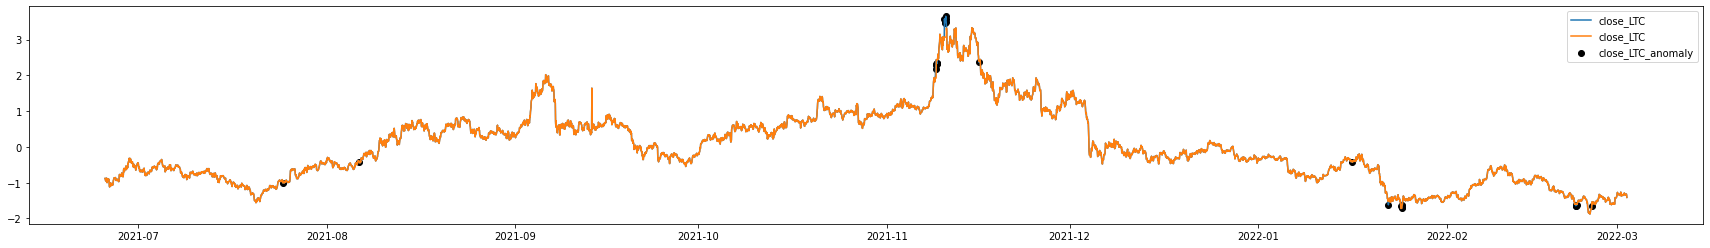

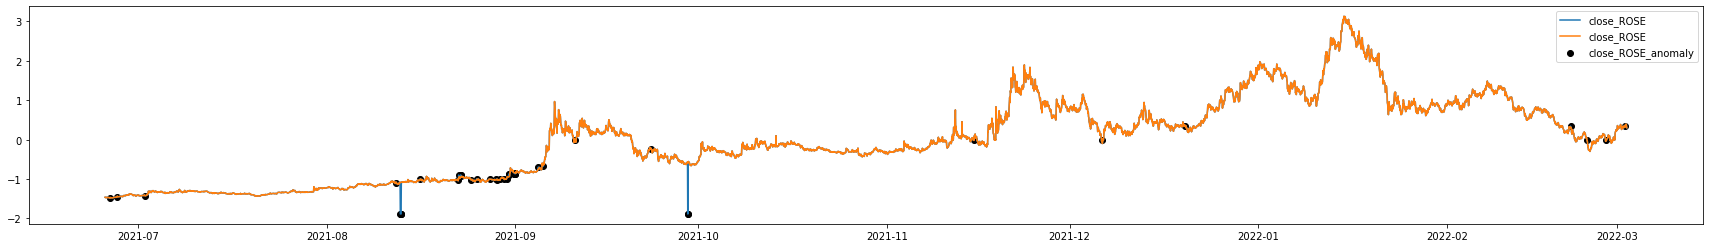

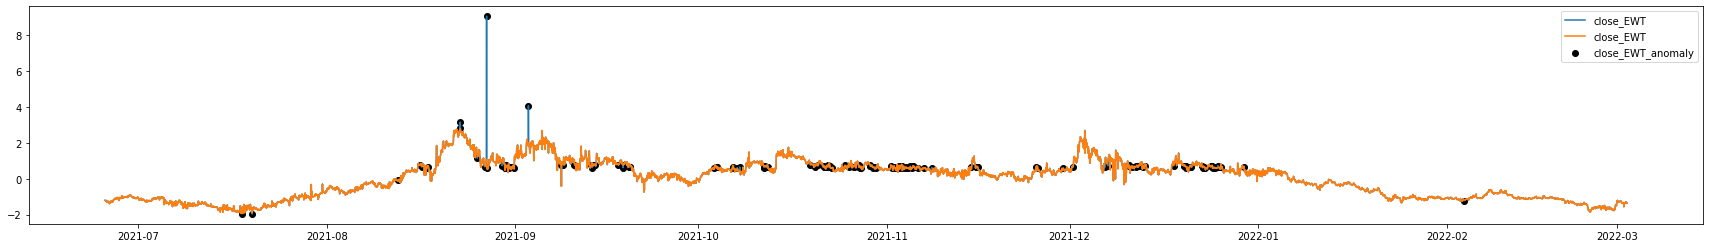

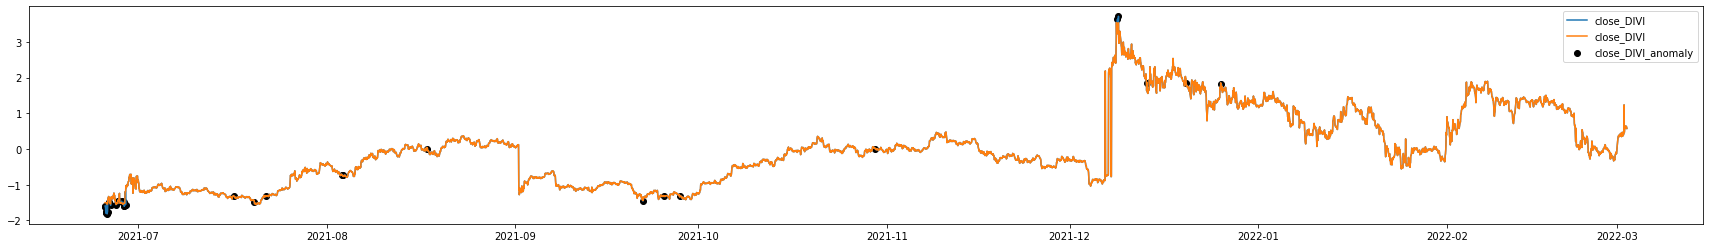

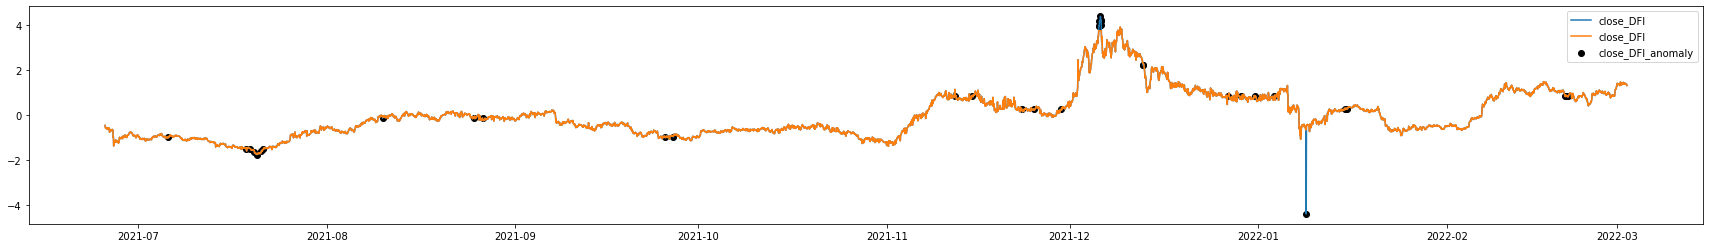

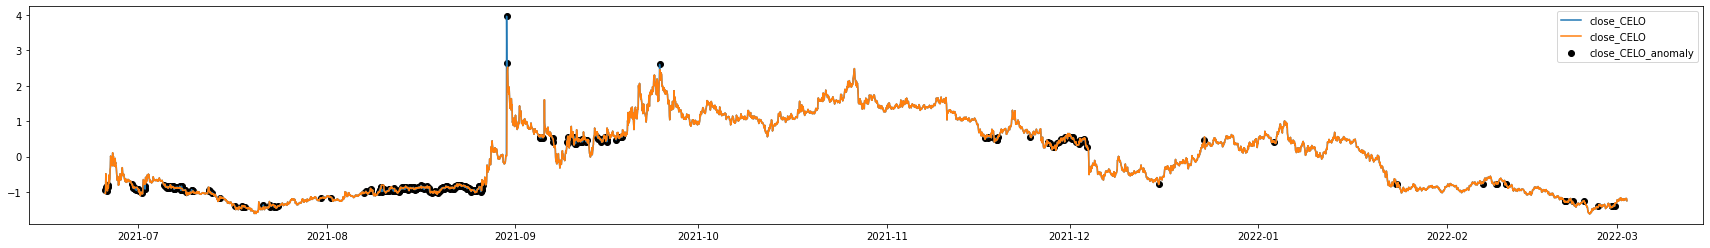

In [105]:
#LOF finds outliers(EWT and ROSE), but also identifies unsuspicious areas(CELO)
#does not require scaling x values (index)
#Better results using neighbor paramters? => Possible

predictions_LOF = []
for currency in currencies_anomalies:
    model = LocalOutlierFactor(n_neighbors=15)#contamination=0.0015)
    predictions_LOF.append(model.fit_predict(df_close_Znorm[[currency]]))

df_named_anomalies = pd.DataFrame(list(np.transpose(predictions_LOF)), index= df_close_Znorm.index, columns= named_anomalies)

for currency, anomaly in zip(currencies_anomalies,named_anomalies):
    fig, ax = plt.subplots(figsize=(30,4))
    loc = df_named_anomalies.loc[df_named_anomalies[anomaly]==-1,[anomaly]]
    entry = pd.concat([loc,df_close_Znorm[currency]], axis=1 , join='inner')
    ax.plot(df_close_Znorm.index, df_close_Znorm[currency], label=currency)
    ax.scatter(entry.index, entry[currency], marker ='o', color='black', label = anomaly)
    df_close_Znorm.loc[entry.index, currency] = np.nan
    df_close_Znorm.fillna(method='ffill', inplace = True)
    df_close_Znorm.fillna(method='bfill', inplace = True) #different fill methode in case first value is nan
    ax.plot(df_close_Znorm.index, df_close_Znorm[currency], label=currency)
    plt.legend()
    plt.show()
#

In [106]:
x = df_close.values #returns a numpy array
x_Zscaled = preprocessing.StandardScaler().fit_transform(x)
df_close_Znorm = pd.DataFrame(x_Zscaled, index= df_close.index, columns= df_close.columns)
df_close_Znorm.sort_index(inplace=True)
#df_close_Znorm.set_index(df_unix['unix'], inplace=True)
#df_close_Znorm.head(3)

### OCSVM

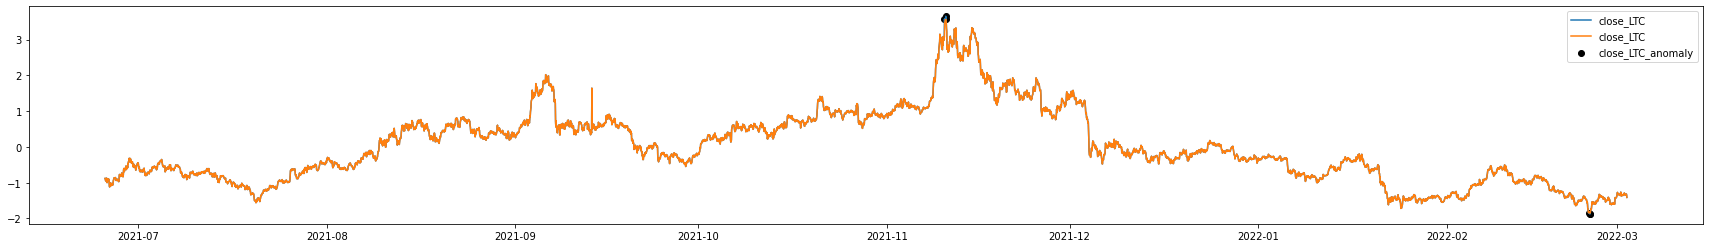

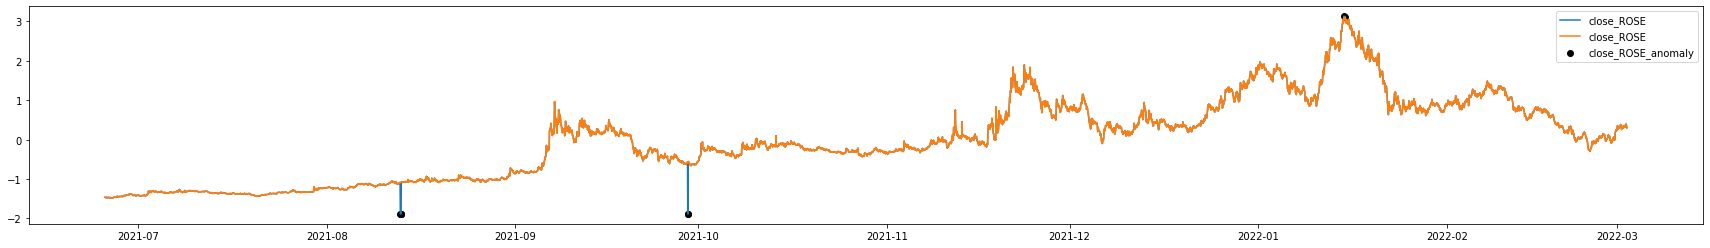

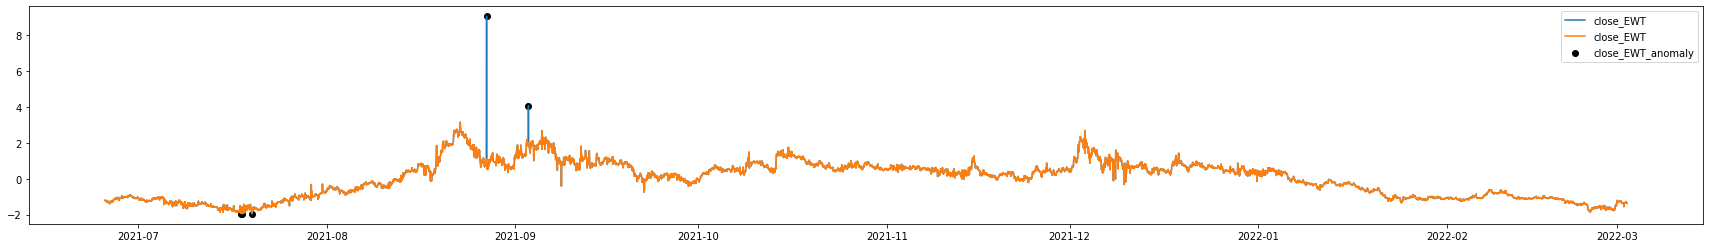

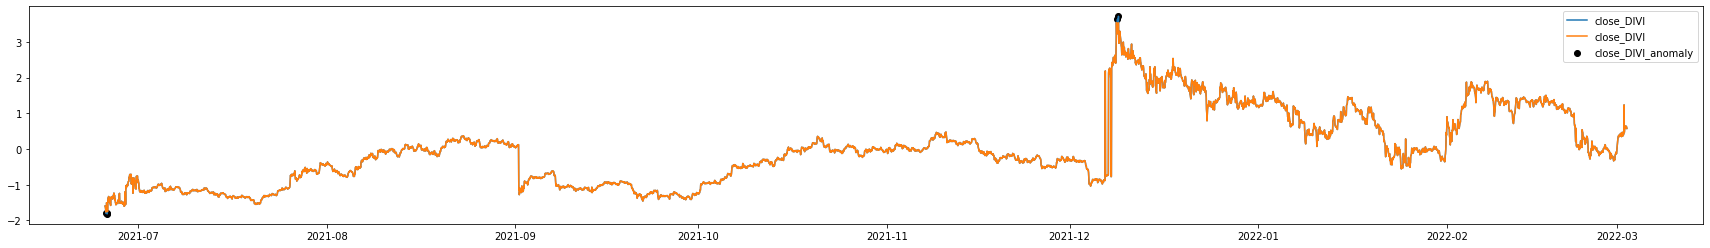

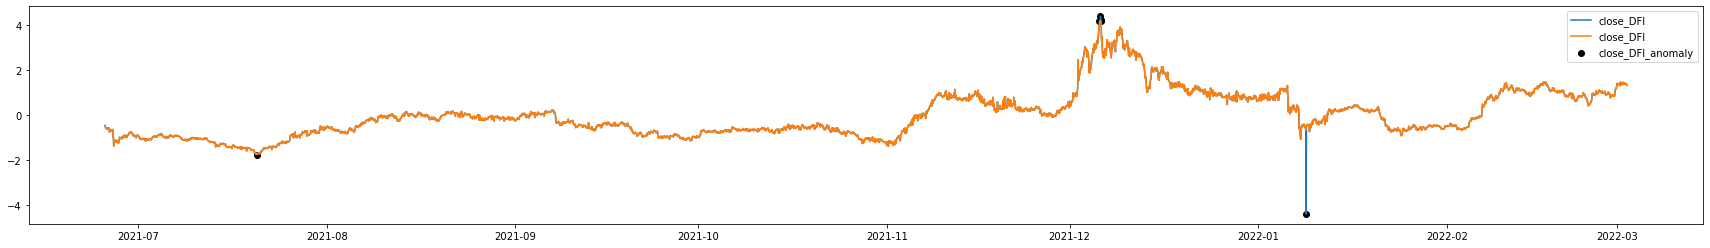

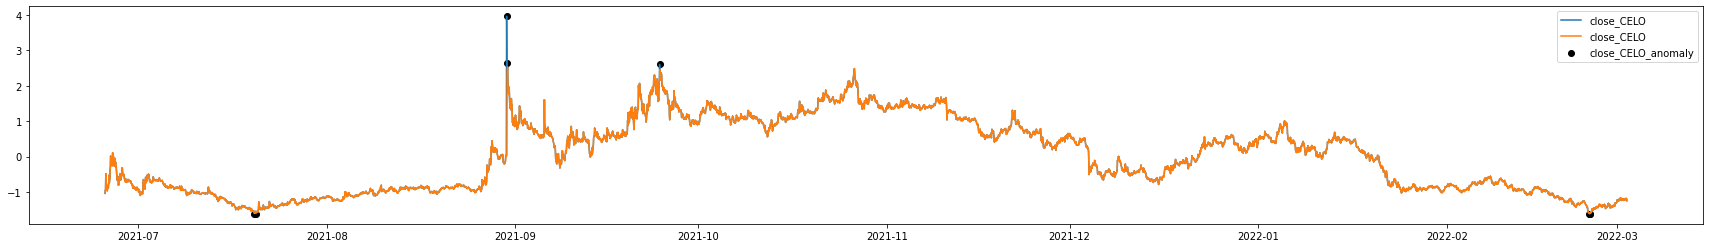

In [107]:
predictions_OCSVM = []
for currency in currencies_anomalies:
    model = OneClassSVM(gamma=0.01, nu=0.001)
    predictions_OCSVM.append(model.fit_predict(df_close_Znorm[[currency]]))

df_named_anomalies = pd.DataFrame(list(np.transpose(predictions_OCSVM)), index= df_close_Znorm.index, columns= named_anomalies)
#fig, ax = plt.subplots(figsize=(30,6))
for currency, anomaly in zip(currencies_anomalies,named_anomalies):
    fig, ax = plt.subplots(figsize=(30,4))
    loc = df_named_anomalies.loc[df_named_anomalies[anomaly]==-1,[anomaly]]
    entry = pd.concat([loc,df_close_Znorm[currency]], axis=1 , join='inner')
    ax.plot(df_close_Znorm.index, df_close_Znorm[currency], label=currency)
    ax.scatter(entry.index, entry[currency], marker ='o', color='black', label = anomaly)
    df_close_Znorm.loc[entry.index, currency] = np.nan
    df_close_Znorm.fillna(method='ffill', inplace = True)
    df_close_Znorm.fillna(method='bfill', inplace = True) #different fill methode in case first value is nan
    ax.plot(df_close_Znorm.index, df_close_Znorm[currency], label=currency)
    plt.legend()
    plt.show()
#

In [108]:
x = df_close.values #returns a numpy array
x_Zscaled = preprocessing.StandardScaler().fit_transform(x)
df_close_Znorm = pd.DataFrame(x_Zscaled, index= df_close.index, columns= df_close.columns)
df_close_Znorm.sort_index(inplace=True)
#df_close_Znorm.set_index(df_unix['unix'], inplace=True)
#df_close_Znorm.head(3)

### DBSCAN

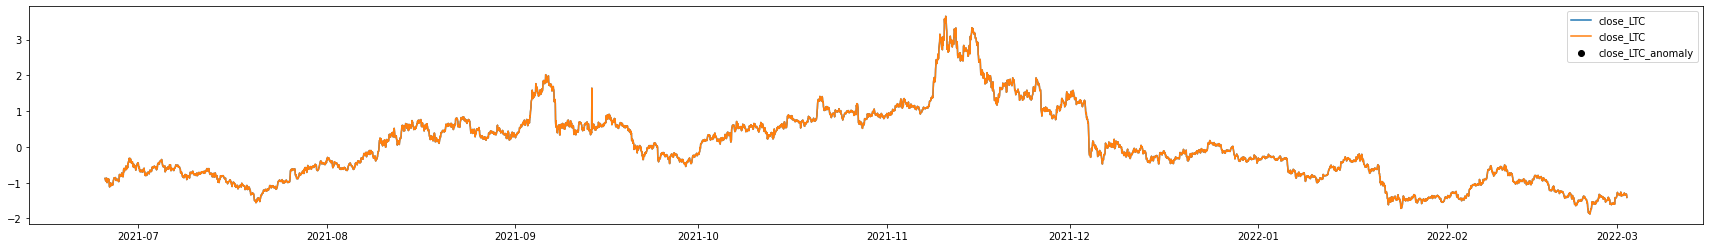

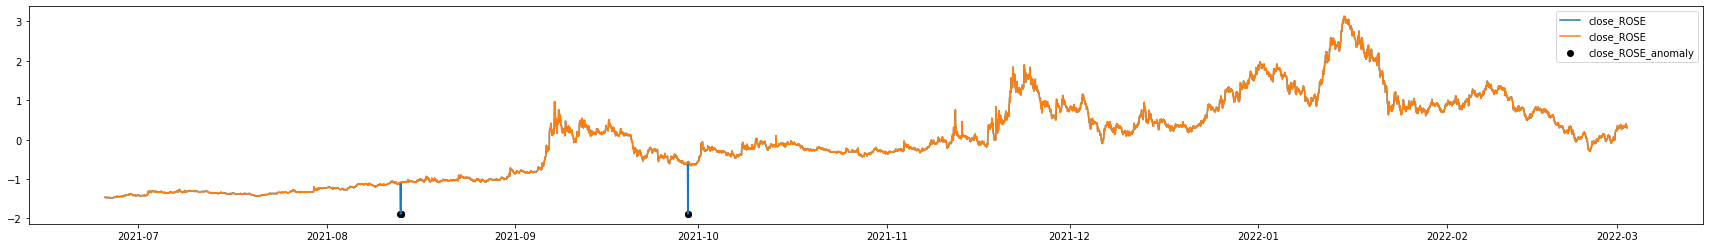

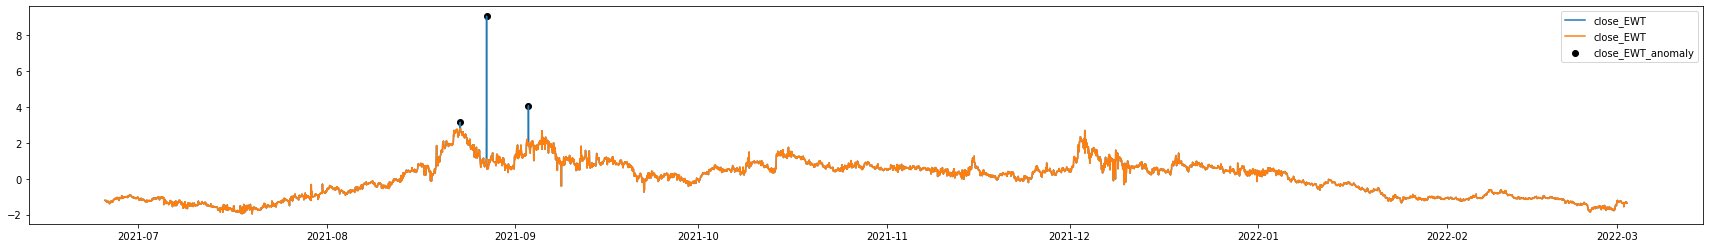

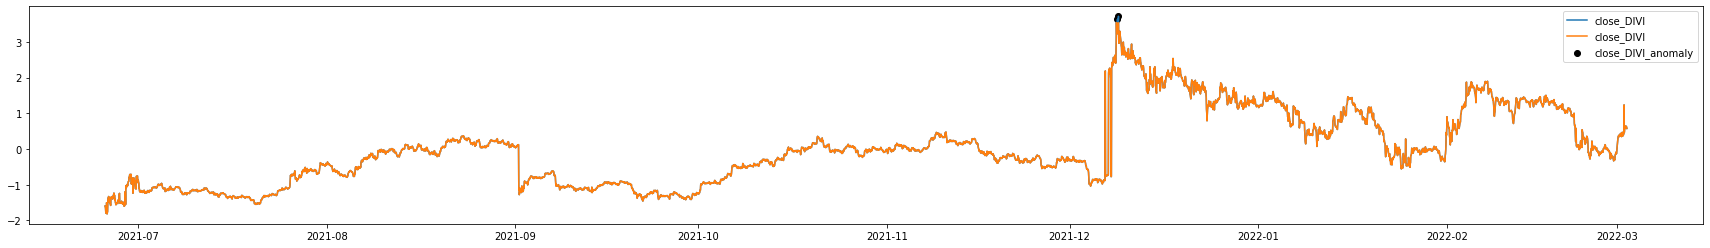

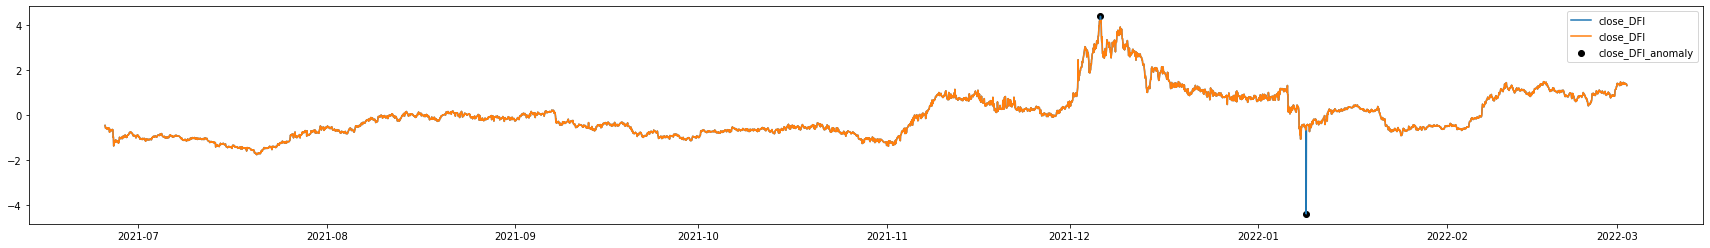

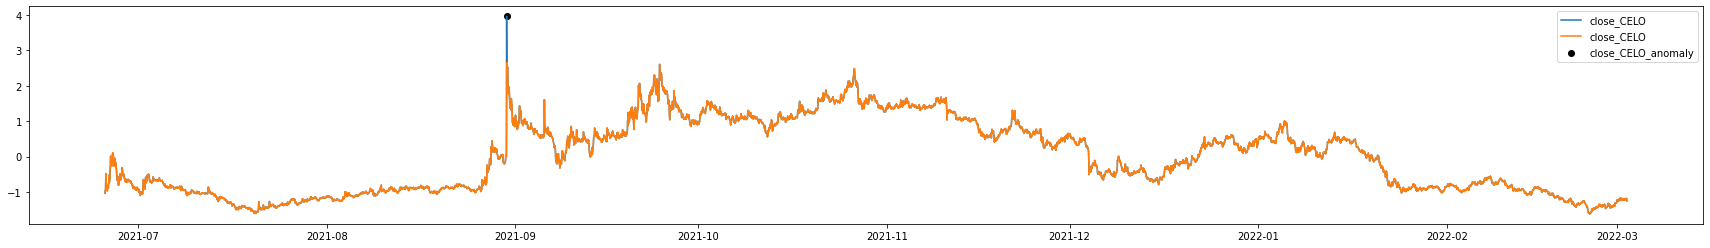

In [109]:
predictions_DBSCAN = []
for currency in currencies_anomalies:
    model = DBSCAN(eps=0.2, min_samples=10)
    predictions_DBSCAN.append(model.fit_predict(df_close_Znorm[[currency]]))

df_named_anomalies = pd.DataFrame(list(np.transpose(predictions_DBSCAN)), index= df_close_Znorm.index, columns= named_anomalies)
#fig, ax = plt.subplots(figsize=(30,6))
for currency, anomaly in zip(currencies_anomalies,named_anomalies):
    fig, ax = plt.subplots(figsize=(30,4))
    loc = df_named_anomalies.loc[df_named_anomalies[anomaly]==-1,[anomaly]]
    entry = pd.concat([loc,df_close_Znorm[currency]], axis=1 , join='inner')
    ax.plot(df_close_Znorm.index, df_close_Znorm[currency], label=currency)
    ax.scatter(entry.index, entry[currency], marker ='o', color='black', label = anomaly)
    df_close_Znorm.loc[entry.index, currency] = np.nan
    df_close_Znorm.fillna(method='ffill', inplace = True)
    df_close_Znorm.fillna(method='bfill', inplace = True) #different fill methode in case first value is nan
    ax.plot(df_close_Znorm.index, df_close_Znorm[currency], label=currency)
    plt.legend()
    plt.show()
#

In [110]:
x = df_close.values #returns a numpy array
x_Zscaled = preprocessing.StandardScaler().fit_transform(x)
df_close_Znorm = pd.DataFrame(x_Zscaled, index= df_close.index, columns= df_close.columns)
df_close_Znorm.sort_index(inplace=True)
#df_close_Znorm.set_index(df_unix['unix'], inplace=True)
#df_close_Znorm.head(3)

### Try Moving average for smoothing (no automatic replacing)

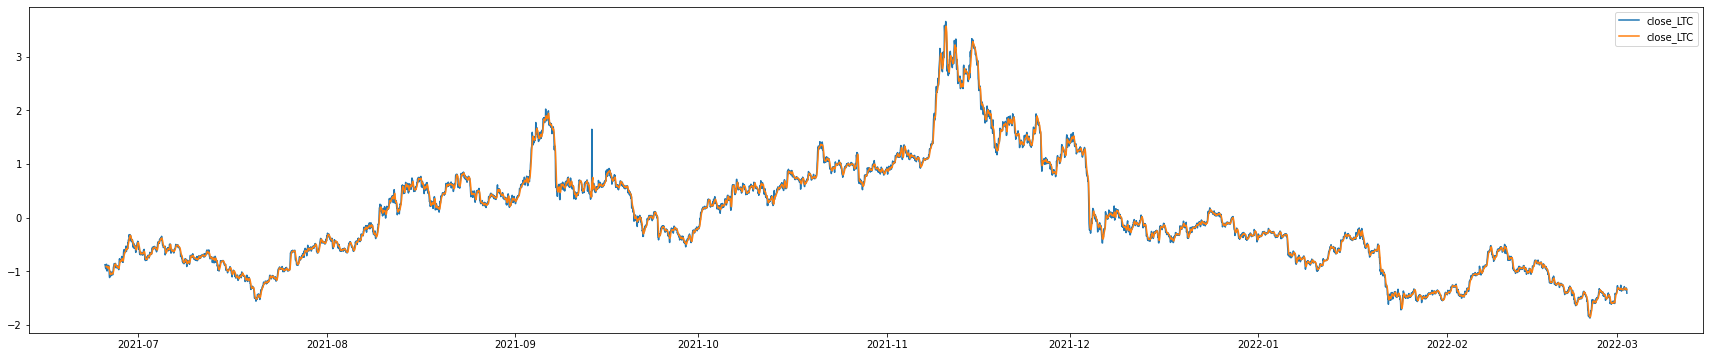

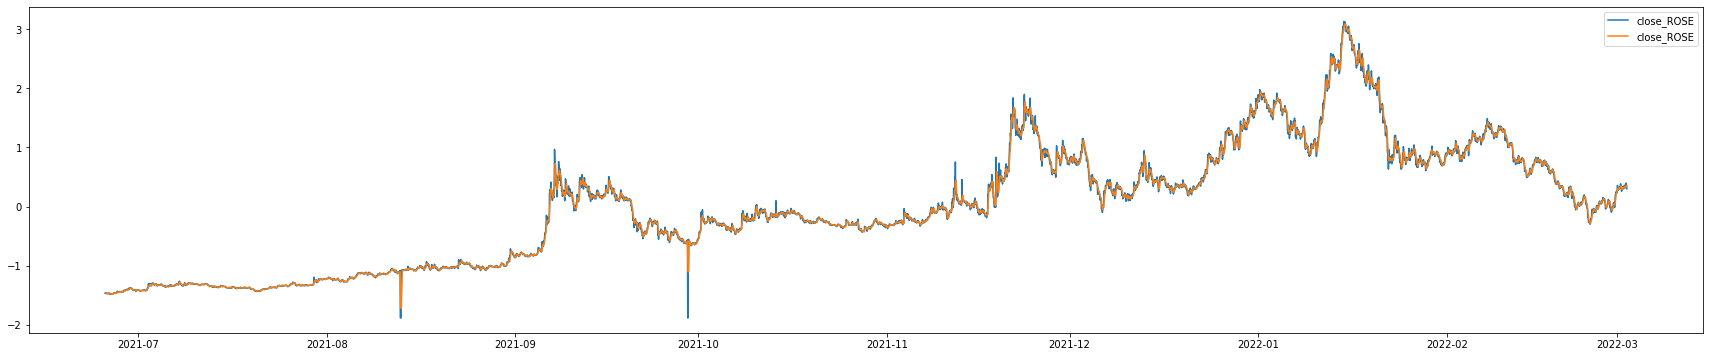

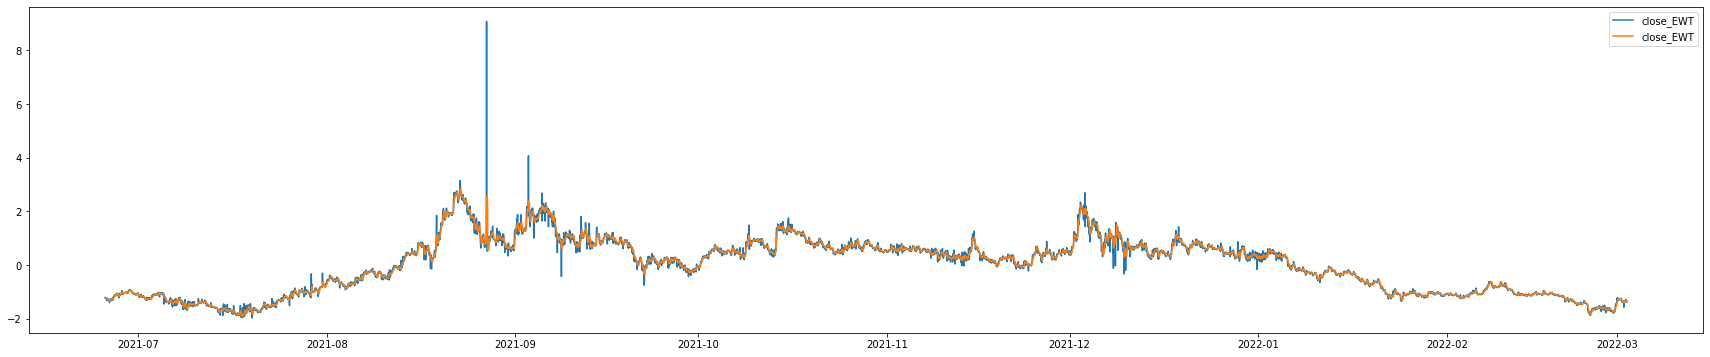

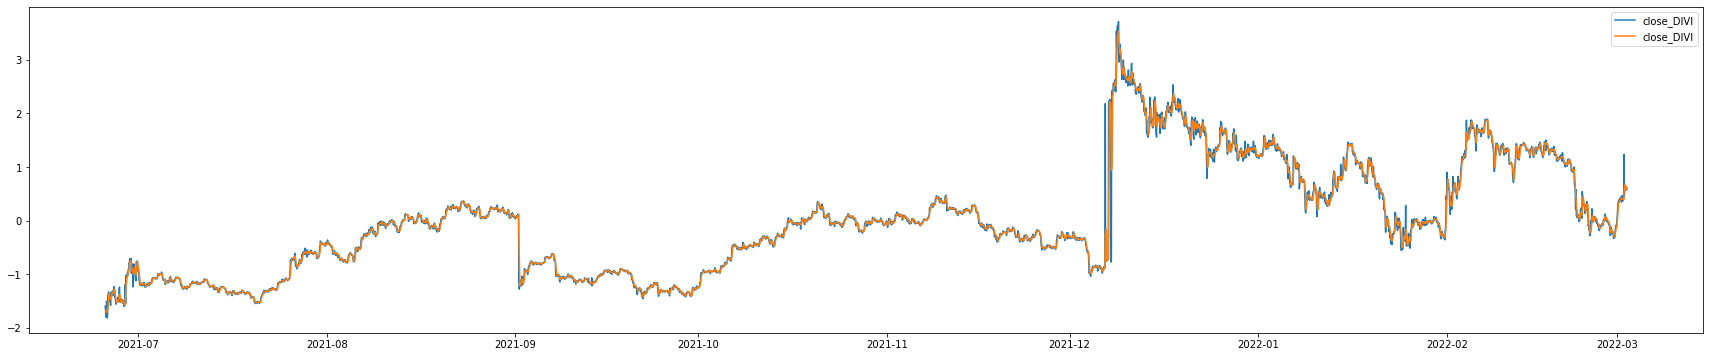

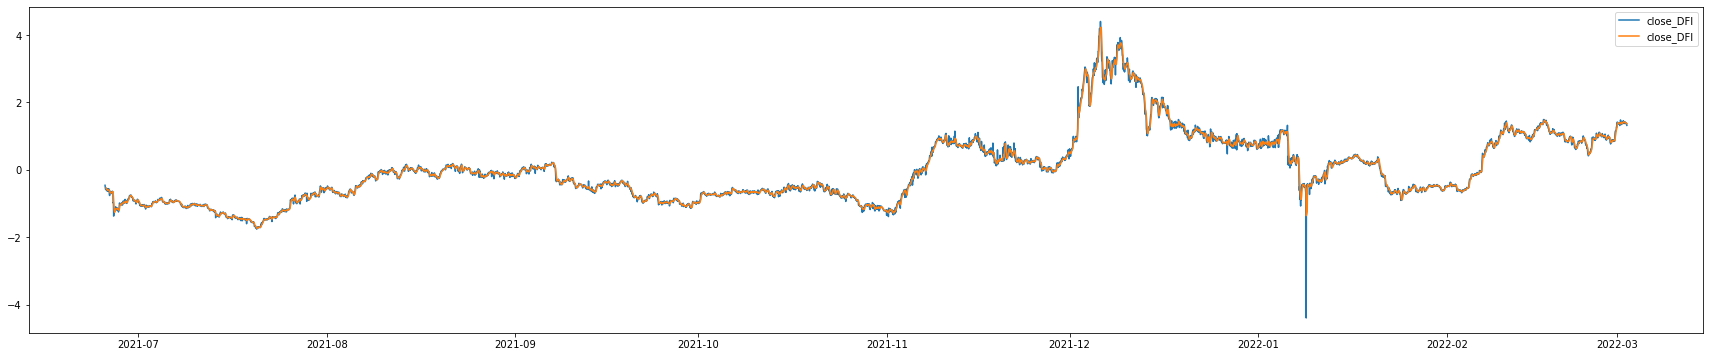

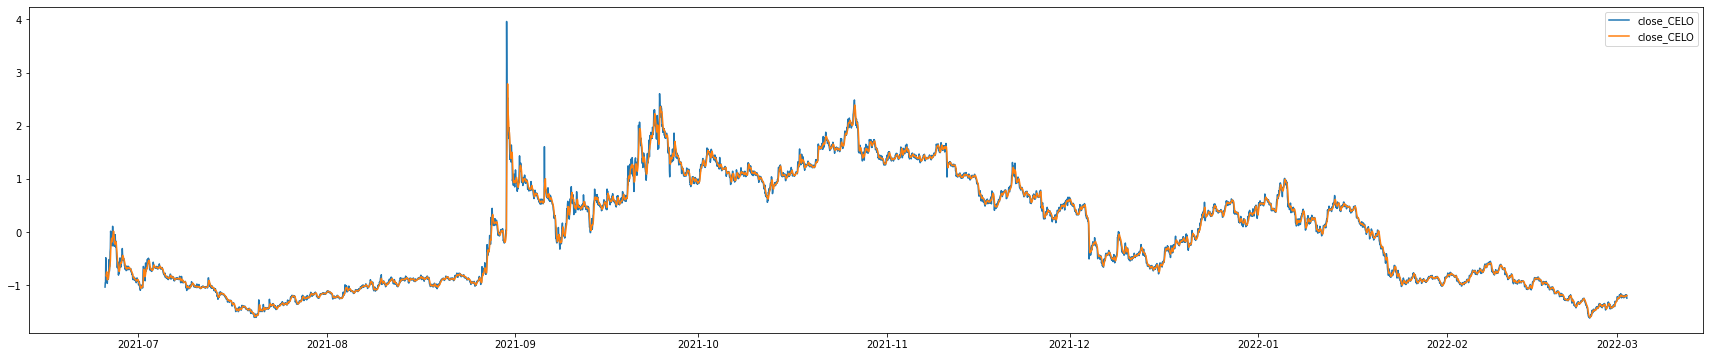

In [111]:
for currency in currencies_anomalies:
    fig, ax = plt.subplots(figsize=(30,6))
    ax.plot(df_close_Znorm.index, df_close_Znorm[currency], label=currency)
    ax.plot(df_close_Znorm.index, df_close_Znorm[currency].rolling(5).mean(), label=currency)
    plt.legend()
    plt.show()
#

### Lowpass

# Start of ML

Aim:<br>
Use prices of Mo-Fr to predict price of currency on So. 
<br>
Target Feature is diffence of currency between Fr and So in [%]

First step: <br>
Look what currencies or features to use + define target currency

### Analyse correlation matrix of prices to find "independent" currencies

ADA and DOGE are noticable. Correlation is low to most of the other currencies. (But not to each other)
<br>
Also DIVI and DFI have low correlation to a couple of currencies. 
<br>
But DIVI had a jumpy plot, this could be a explanation for the low correlation.
<br>
ADA chosen as target currency
<br>
Maybe check Autoregression and ARIMR models to predict!

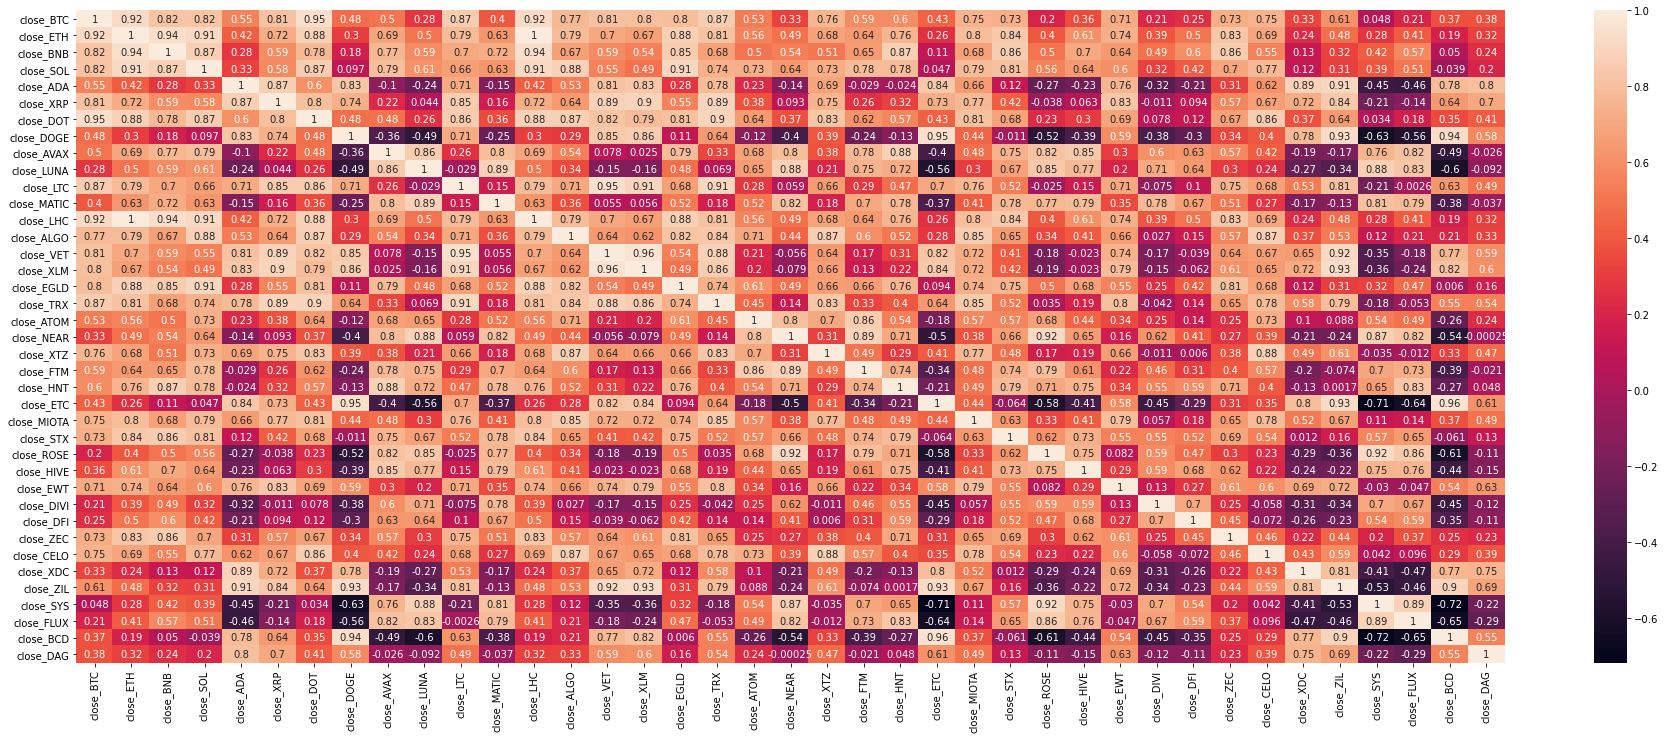

In [112]:
corr_matrix = df_close_Znorm.corr()
plt.figure(figsize=(32,12))
plt.xticks()
sn.heatmap(corr_matrix, annot=True)
plt.show()
#corr_matrix.sum()

### Use currencies as features that have low correlation to ADA

In [113]:
target_currency = 'close_ADA'
corr_currencies = list(corr_matrix.loc[abs(corr_matrix[target_currency])<0.4, [target_currency]].index)
features_corr = df_close_Znorm[corr_currencies]
features_corr.head(3)

close_BNB  close_SOL  close_AVAX  close_LUNA  \
datetime                                                            
2021-06-25 14:00:00  -1.602123  -1.537969   -1.595483   -1.602156   
2021-06-25 15:00:00  -1.611962  -1.544761   -1.599042   -1.602156   
2021-06-25 16:00:00  -1.683190  -1.549855   -1.601414   -1.607710   

                     close_MATIC  close_EGLD  close_ATOM  close_NEAR  \
datetime                                                               
2021-06-25 14:00:00    -1.080447   -1.593817   -1.884311   -1.497997   
2021-06-25 15:00:00    -1.118255   -1.601806   -1.887323   -1.501042   
2021-06-25 16:00:00    -1.162735   -1.613903   -1.912388   -1.509943   

                     close_FTM  close_HNT  close_STX  close_ROSE  close_HIVE  \
datetime                                                                       
2021-06-25 14:00:00  -1.485194  -1.352189  -2.142648   -1.462793   -1.388085   
2021-06-25 15:00:00  -1.485634  -1.377995  -2.142008   -1.465262   -1.390769   
2021-06-25 16:00:00  -1.489822  -1.407770  -2.153536   -1.462623   -1.394279   

                     close_DIVI  close_DFI  close_ZEC  
datetime                                               
2021-06-25 14:00:00   -1.598995  -0.455787  -0.969744  
2021-06-25 15:00:00   -1.613889  -0.517743  -0.995330  
2021-06-25 16:00:00   -1.666373  -0.578069  -1.055127

### Use PCA to find new features that explain most of variance in the data and use them for prediction

In [114]:
# 3 Components explain 86% of variance
pca = PCA(n_components=3)
pc = pca.fit_transform(df_close_Znorm)
features_pc = pd.DataFrame(data=pc, index=df_close_Znorm.index, columns=['PC1', 'PC2', 'PC3'])
pca.explained_variance_ratio_

array([0.48198235, 0.31971569, 0.05828129])

In [115]:
features_pc.head(3)

PC1       PC2       PC3
datetime                                         
2021-06-25 14:00:00  7.623914  2.147779 -0.683261
2021-06-25 15:00:00  7.688667  2.112546 -0.612056
2021-06-25 16:00:00  7.873044  2.004287 -0.502757

# Check Autoregression and ARIMR models to predict!

### Create target Vector with ADA price

In [116]:
liste = [1639306800,1639307800, 1639308800]

In [117]:
delta = datetime.timedelta(days=+1)
delta

datetime.timedelta(days=1)

In [118]:
do = int(datetime.datetime.timestamp(df_raw.index[1]))
do

1624633200

In [119]:
do.weekday

AttributeError: 'int' object has no attribute 'weekday'